# Aprendizado Não Supervisionado para Identificação de Ações Semelhantes no Mercado Financeiro

Leonardo Garcia dos Santos

Ronaldo Ávila de Arruda Junior

#Resumo
Este trabalho utilizou o dataset StockNet para aplicar técnicas de aprendizado não supervisionado na série histórica de ações do mercado financeiro. Foram exploradas três abordagens distintas para a extração de features, com algoritmos de clustering aplicados separadamente em cada uma.

Na primeira abordagem, utilizamos o retorno médio e a volatilidade (desvio padrão dos retornos) como features. Os algoritmos k-means e agrupamento hierárquico geraram clusters baseados predominantemente na volatilidade.

Na segunda abordagem, ajustamos uma regressão linear aos preços históricos normalizados de cada ação, utilizando o coeficiente angular da reta e o Erro Médio Quadrático (MSE) como features. Essa análise resultou em clusters formados principalmente com base no coeficiente angular, com alguma influência do MSE, refletindo em grupos de ações com taxas de crescimento consistentes semelhantes.

Na terceira e última abordagem, transformamos os históricos de retornos diários de cada ação em vetores de alta dimensionalidade, onde cada dimensão representava o retorno díario de um dia. Aplicamos o k-means nesse espaço, embora a alta dimensionalidade tenha impactado significativamente a eficiência do algoritmo. Os clusters formados, apesar de mais abstratos, revelaram agrupamentos de ações que frequentemente crescem e caem juntas, como grupos de um mesmo setor econômico.

# Introdução
O mercado de ações é um ambiente de alto risco, caracterizado pela volatilidade e imprevisibilidade nos valores dos ativos, o que torna a previsão precisa de preços futuros praticamente impossível. Diante dessa incerteza, estratégias que protejam carteiras de investimento contra perdas significativas tornam-se essenciais.

Uma das abordagens mais eficazes é a diversificação dos ativos, permitindo que, em caso de eventos adversos que afetem drasticamente o valor de uma ação, o impacto na carteira seja mitigado por investimentos em outros ativos menos afetados. Para isso, investidores podem diversificar com base em classificações de risco fornecidas por agências como Standard & Poor's e Moody's, que analisam fatores financeiros e operacionais das empresas, ou com base no setor de atividade das empresas por trás das ações.

Este projeto propõe a aplicação e avaliação de métodos de aprendizado não supervisionado, especificamente técnicas de clustering, para categorizar ações com base em seus comportamentos históricos. O objetivo é auxiliar na identificação de grupos de ações que possam contribuir para estratégias mais robustas de diversificação.

## Metodologia e Resultados

Para a realização deste trabalho, utilizamos o dataset [StockNet](https://github.com/yumoxu/stocknet-dataset), que contém dados diários de 88 ações de empresas negociadas no mercado financeiro. Os dados abrangem o período de 4 de setembro de 2012 a 1º de setembro de 2017 e incluem informações como preço de abertura, máxima, mínima, fechamento, fechamento ajustado e volume negociado.

In [1]:
#Baixa o dataset que está no repositorio
!git clone https://github.com/leonardogarca/AM_Stock-Clustering.git

import os
import pandas as pd

# Uma lista para guardar os dataframes de cada ação. Depois juntar tudo em um só
dataframes = []

folder_path = "./AM_Stock-Clustering/dataset/raw/"

# Itera por todos os arquivos no diretorio
for file_name in os.listdir(folder_path):
    #Só tem arquivo csv, mas bom distinguir
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        #Pega o nome da ação pelo nome do arquivo
        df['Stock'] = os.path.splitext(file_name)[0]

        dataframes.append(df)

# Realiza o Union das tabelas em uma. Tem linhas vazias por algum motivo
data = pd.concat(dataframes, ignore_index=True).dropna()

data.to_csv("stock_data.csv", index=False)

# Arquivo do dataset com os setores de cada empresa
sectors = pd.read_csv("./AM_Stock-Clustering/dataset/StockTable.txt", sep="\t")
#Remover o $ da sigla da ação para ficar igual ao dataframe com os dados
sectors['Symbol'] = sectors['Symbol'].str.replace('$', '', regex=False)

Cloning into 'AM_Stock-Clustering'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 102 (delta 0), reused 92 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 2.17 MiB | 13.36 MiB/s, done.


<ipython-input-2-1bd60b0af9fd>:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


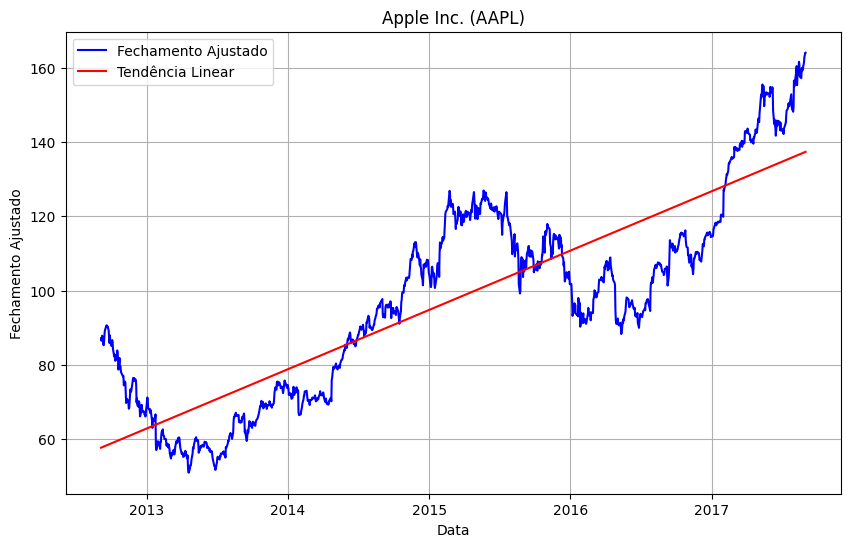

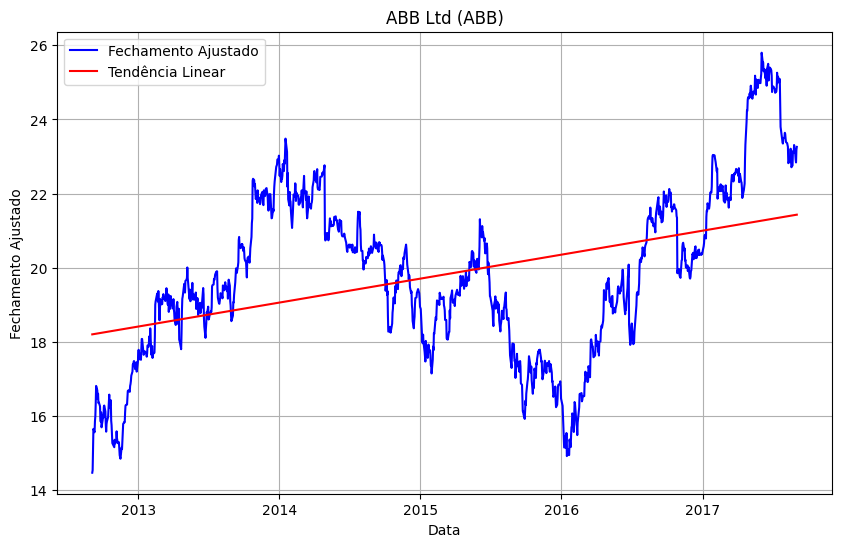

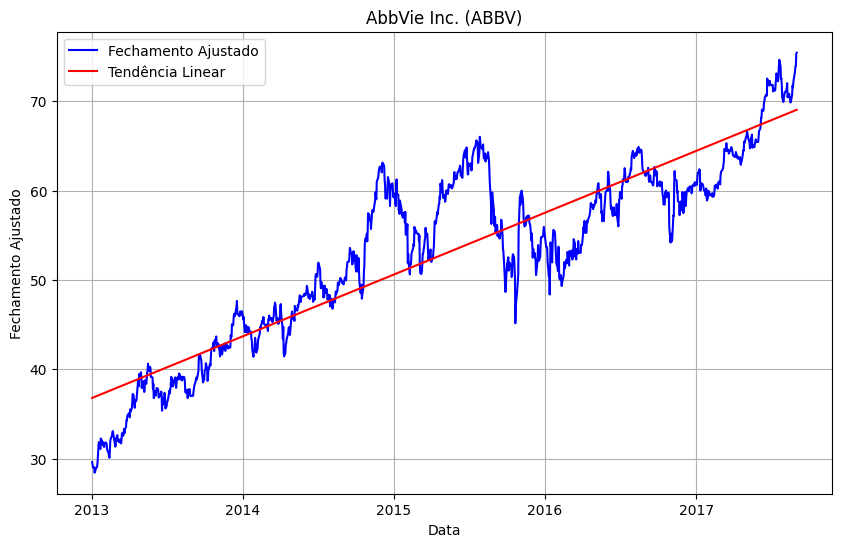

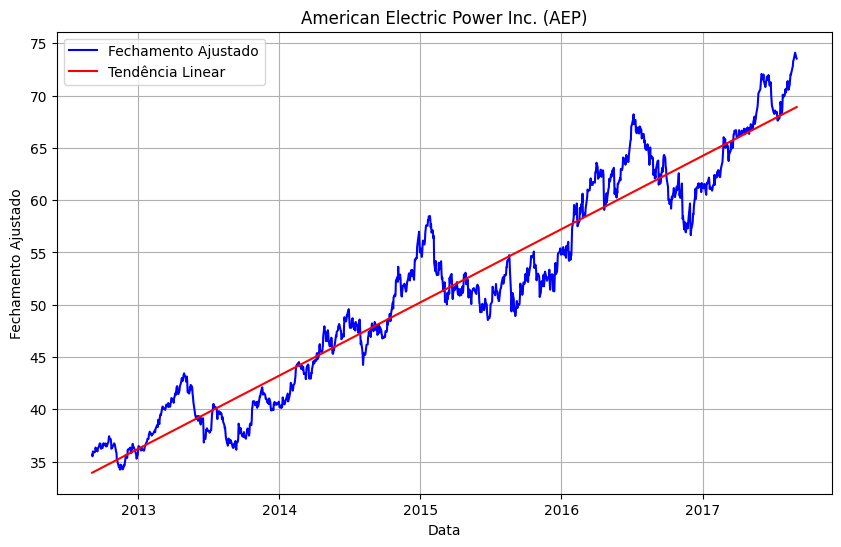

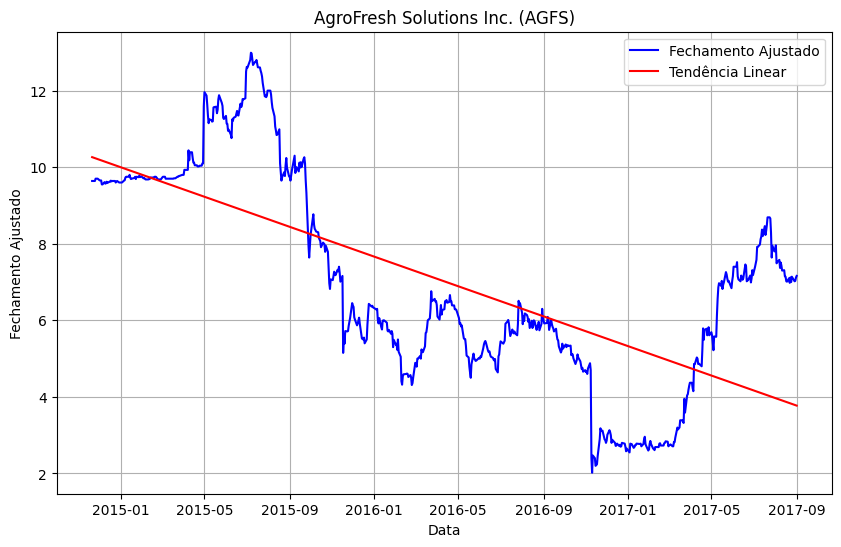

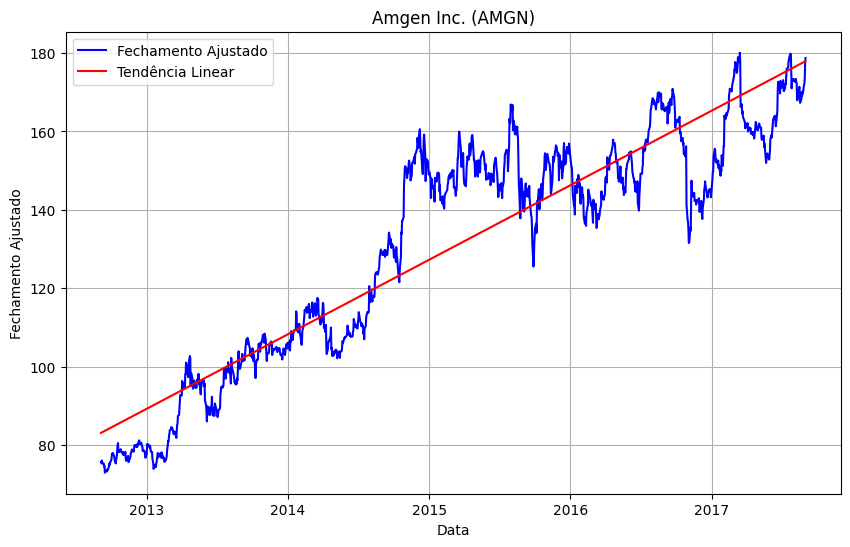

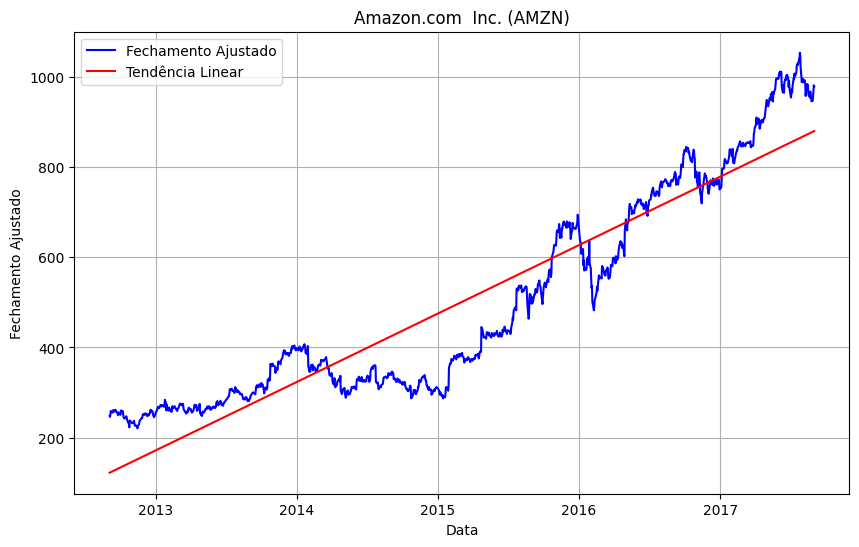

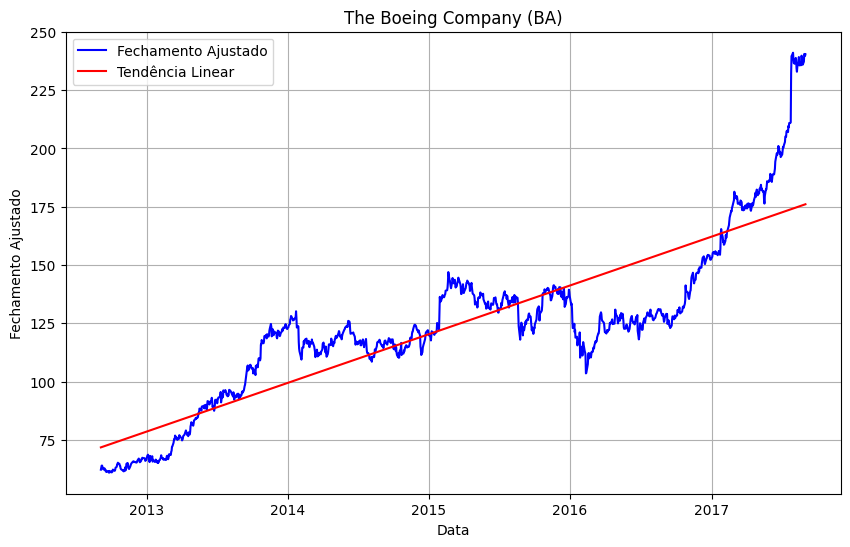

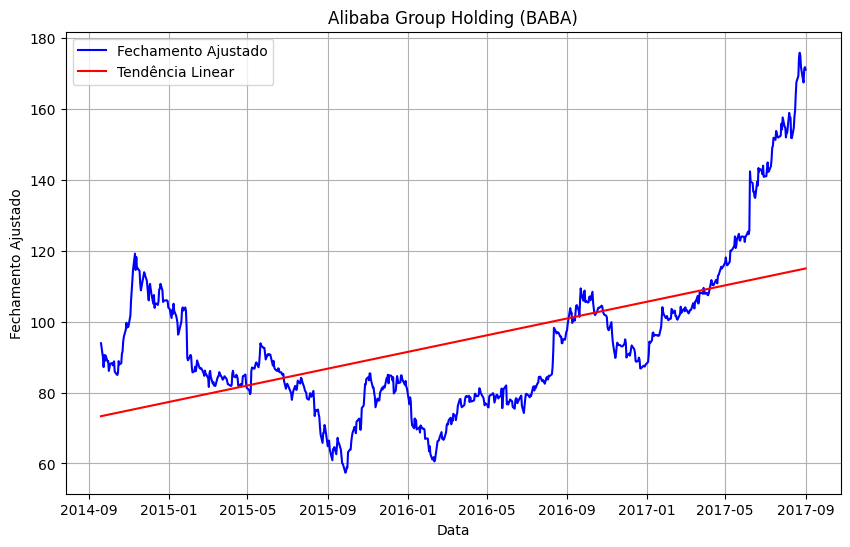

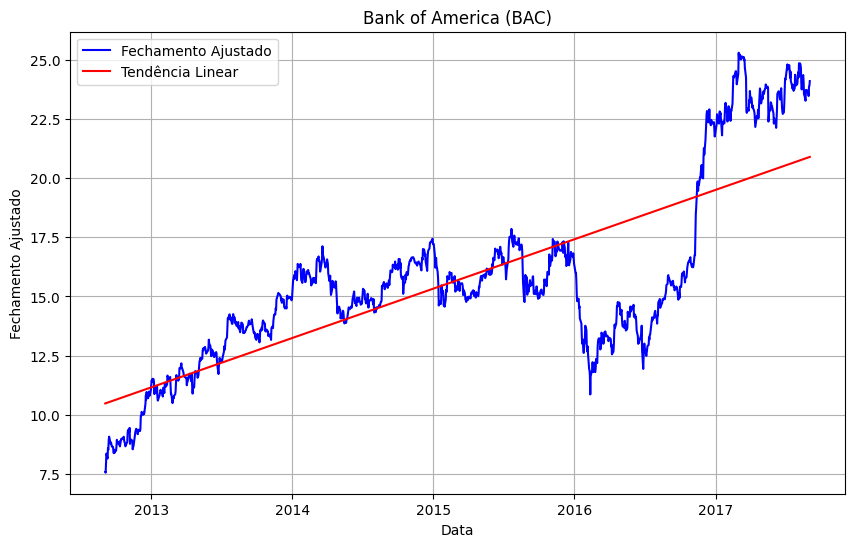

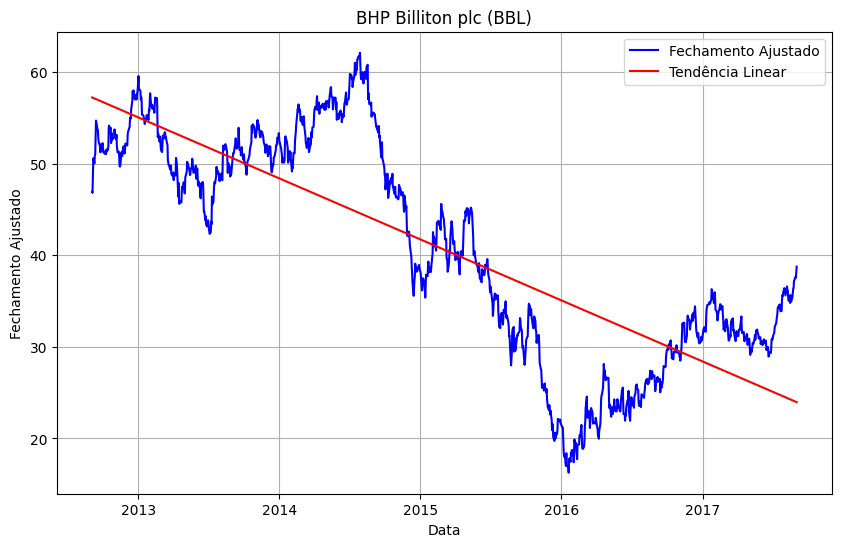

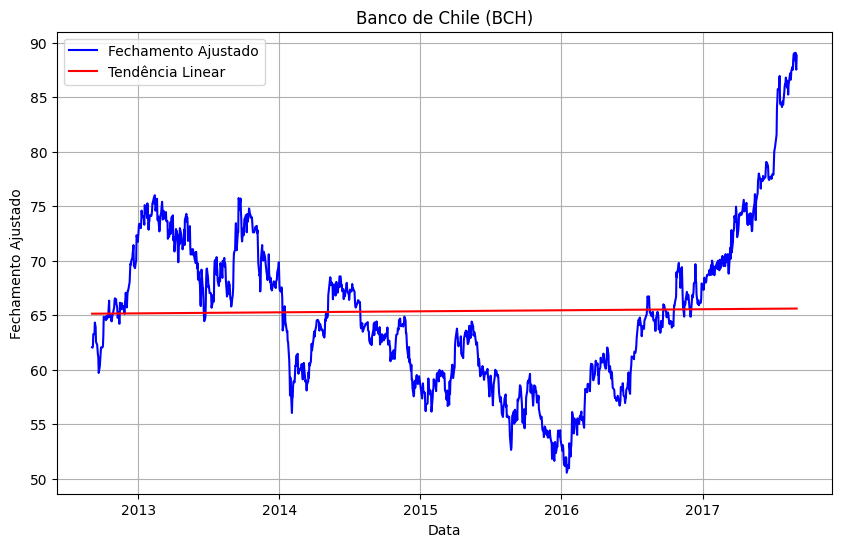

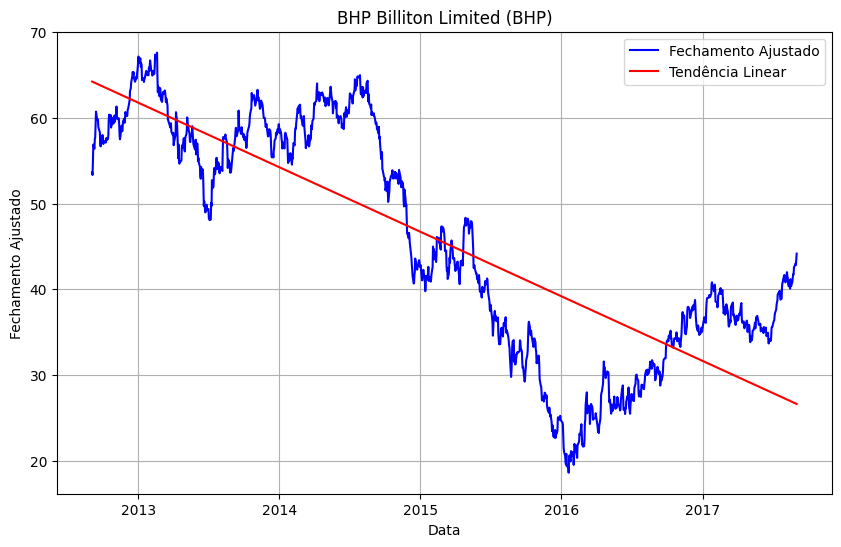

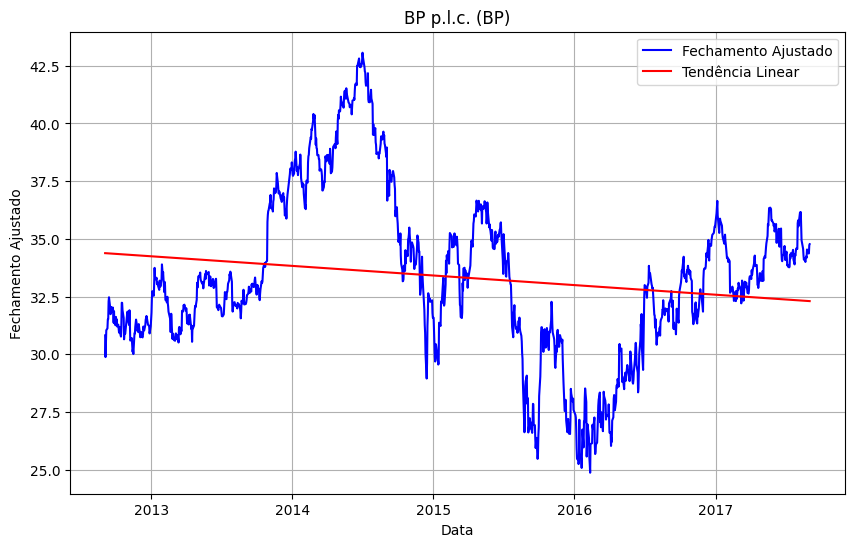

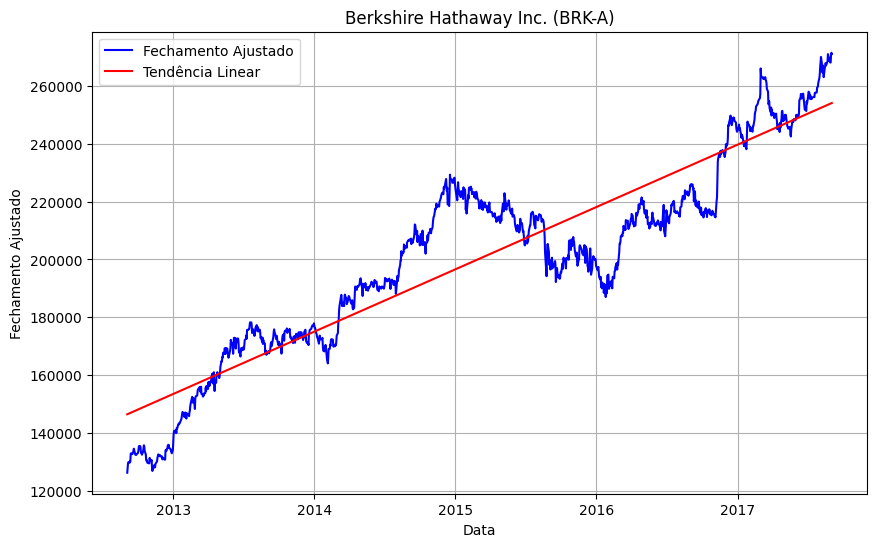

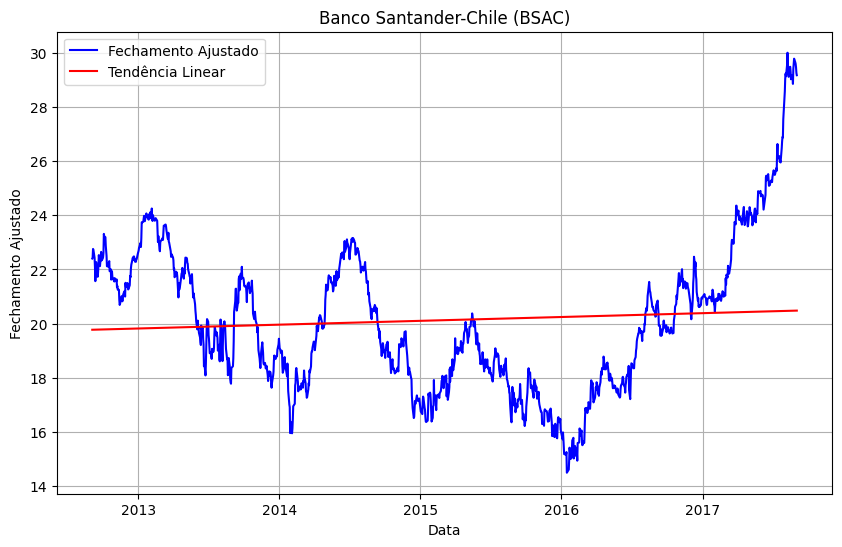

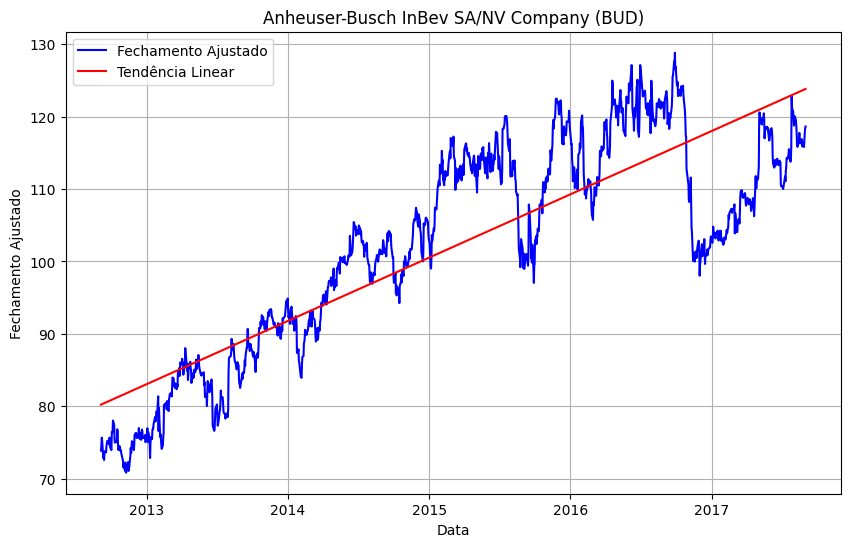

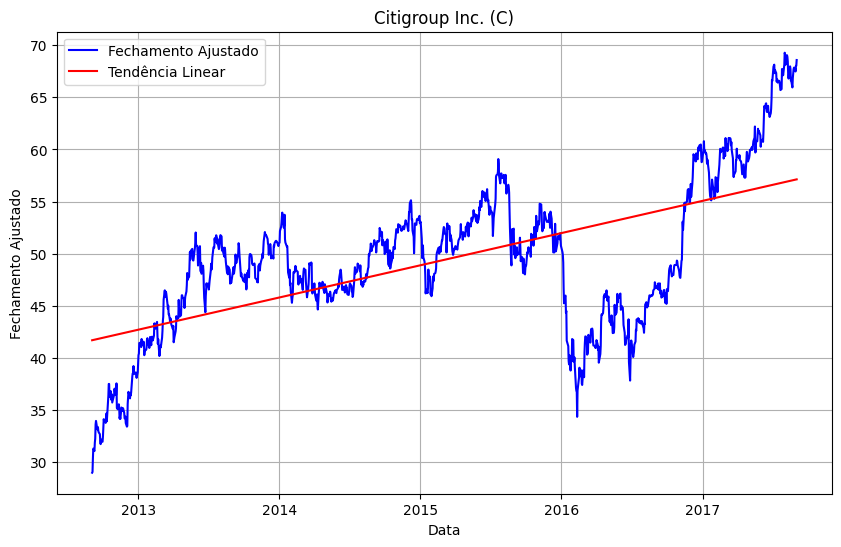

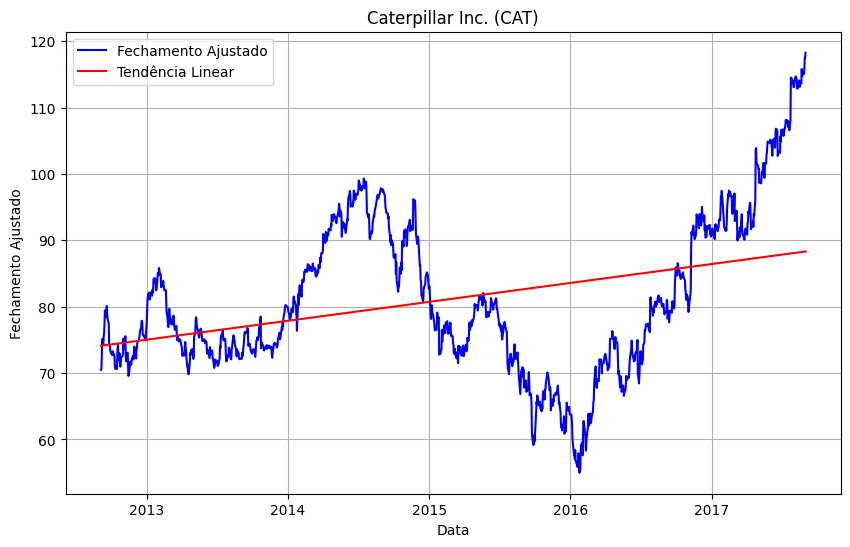

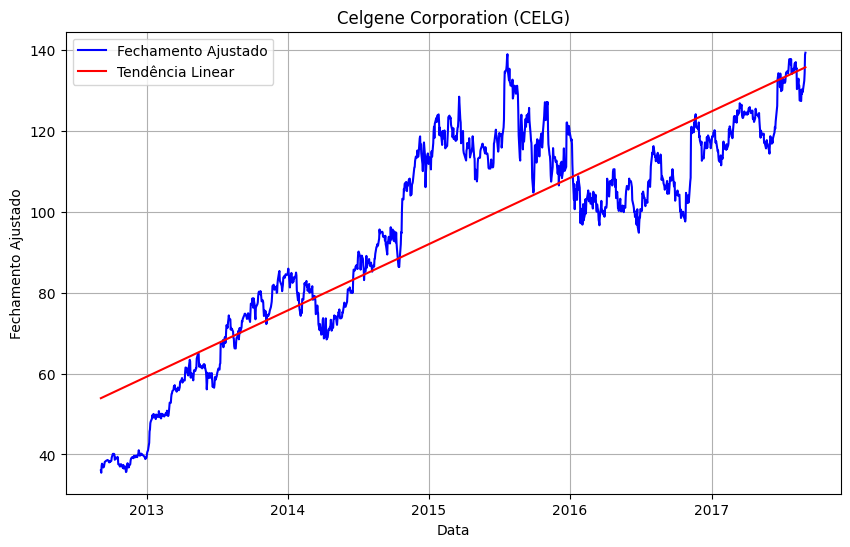

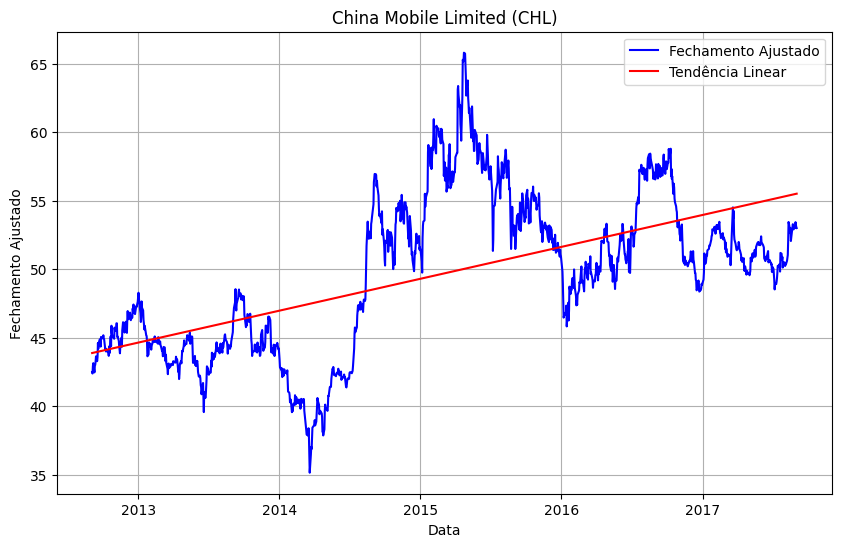

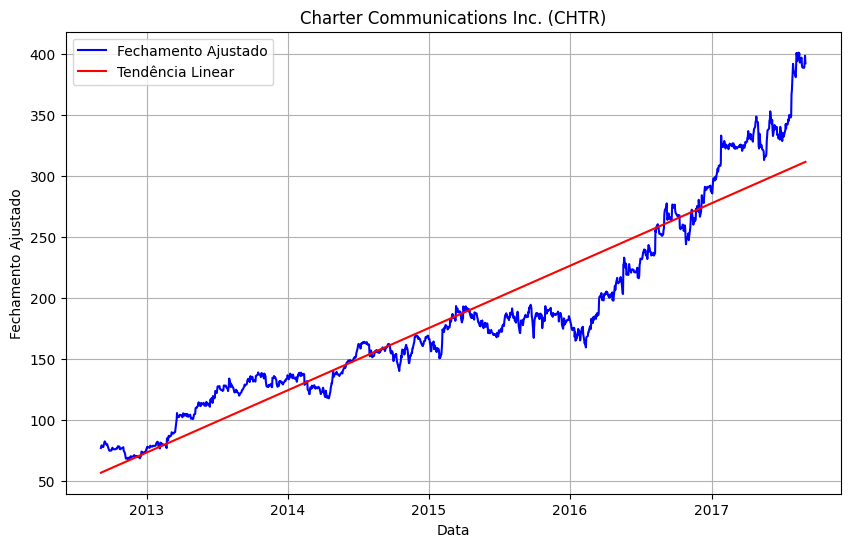

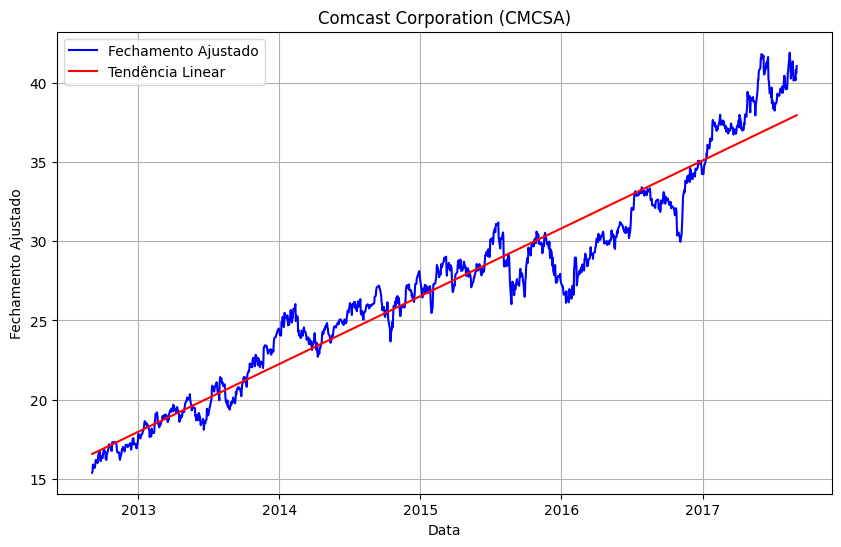

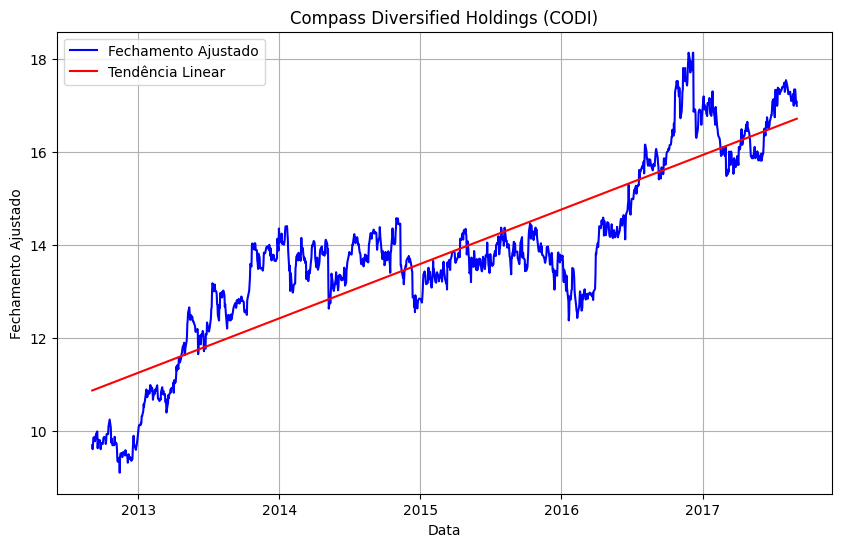

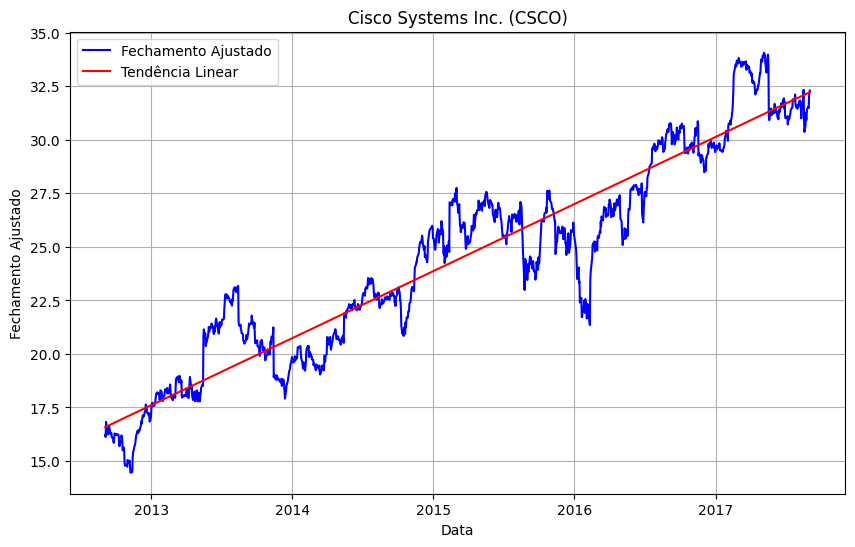

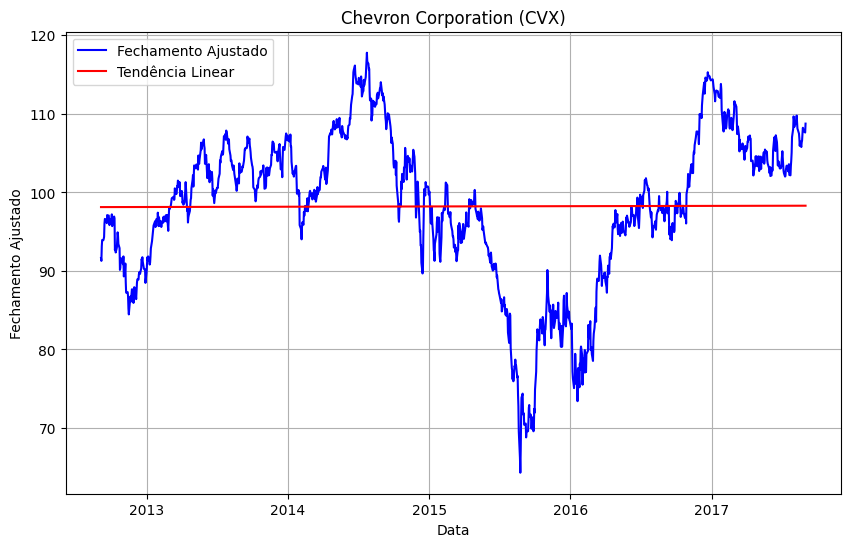

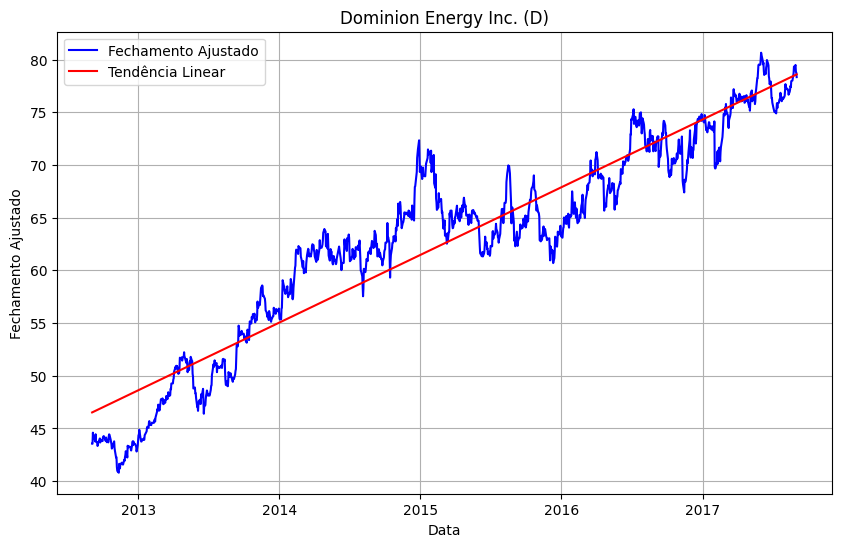

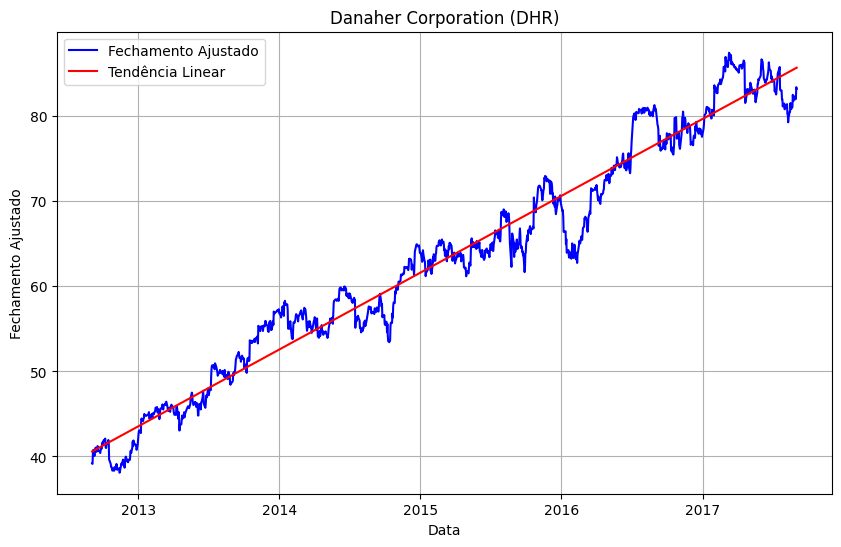

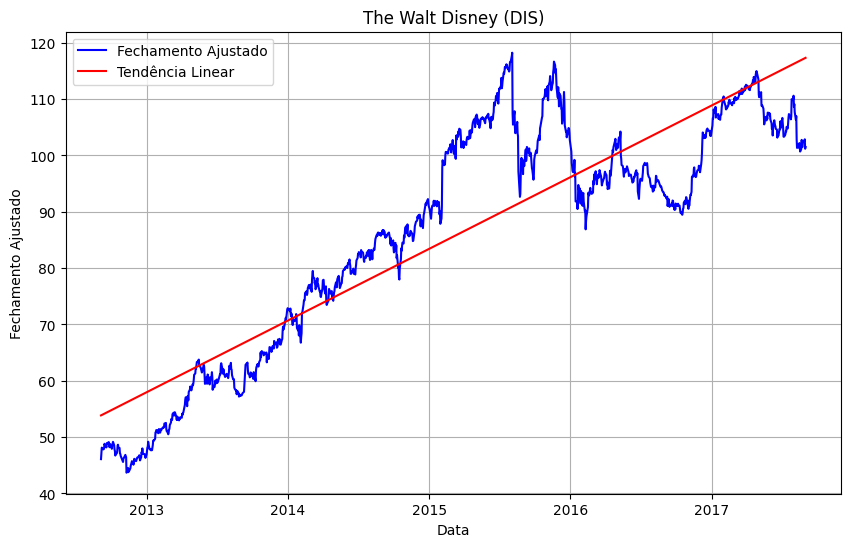

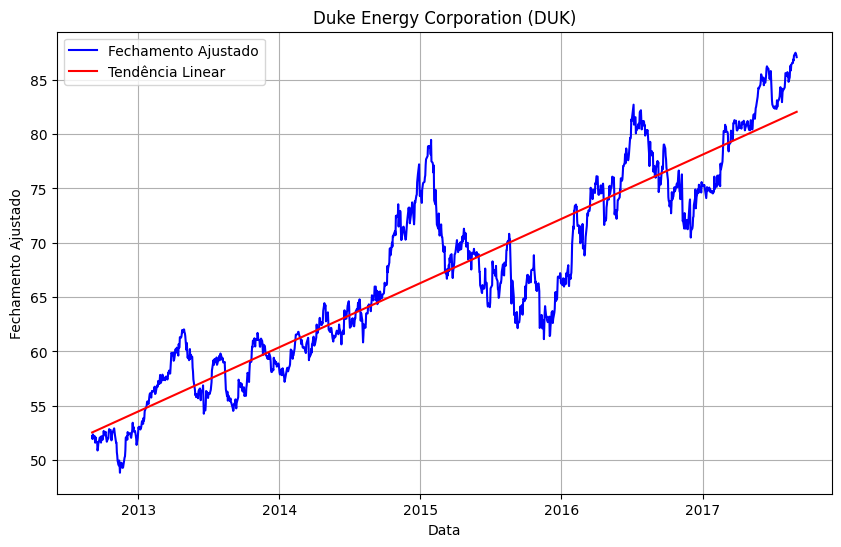

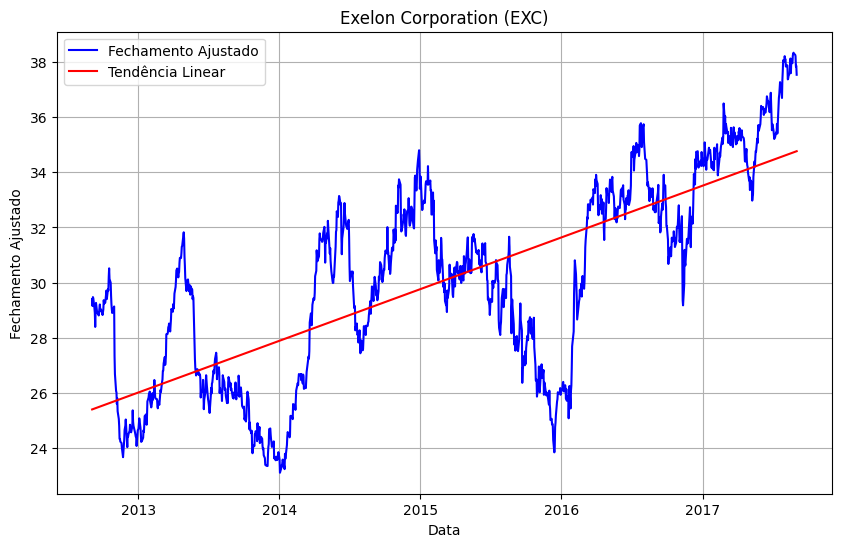

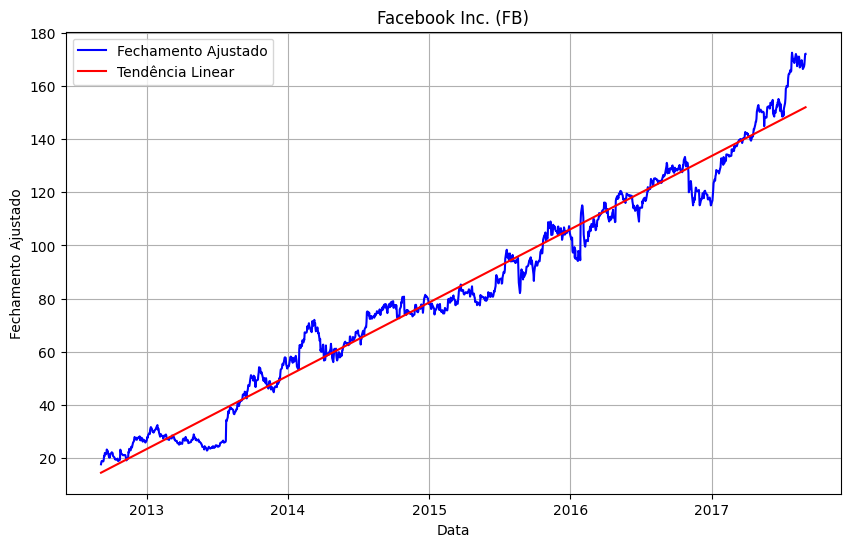

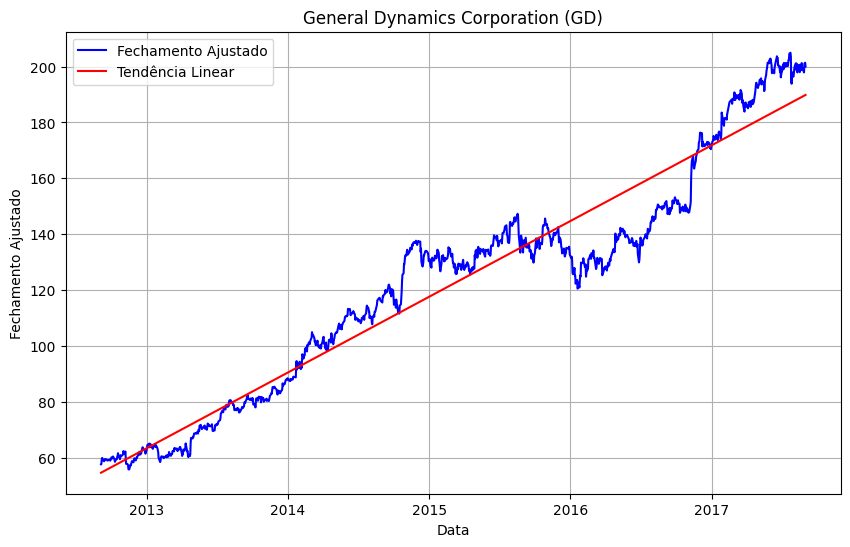

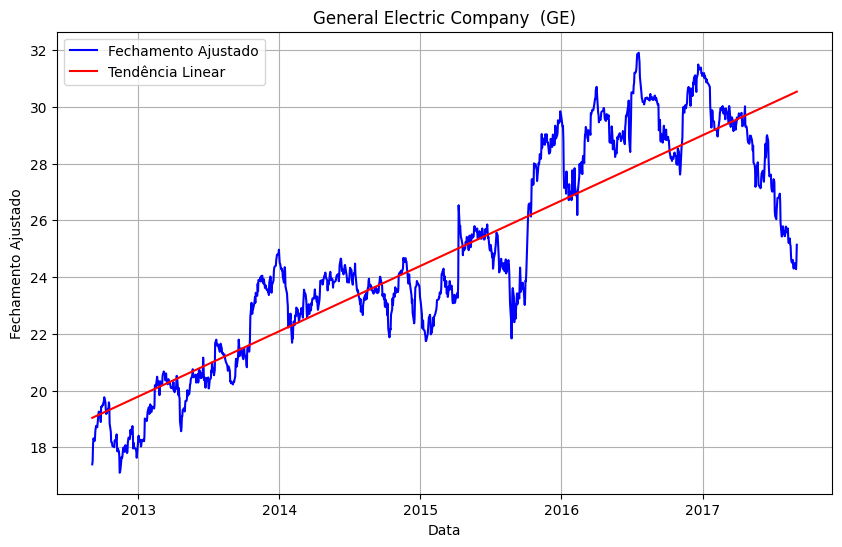

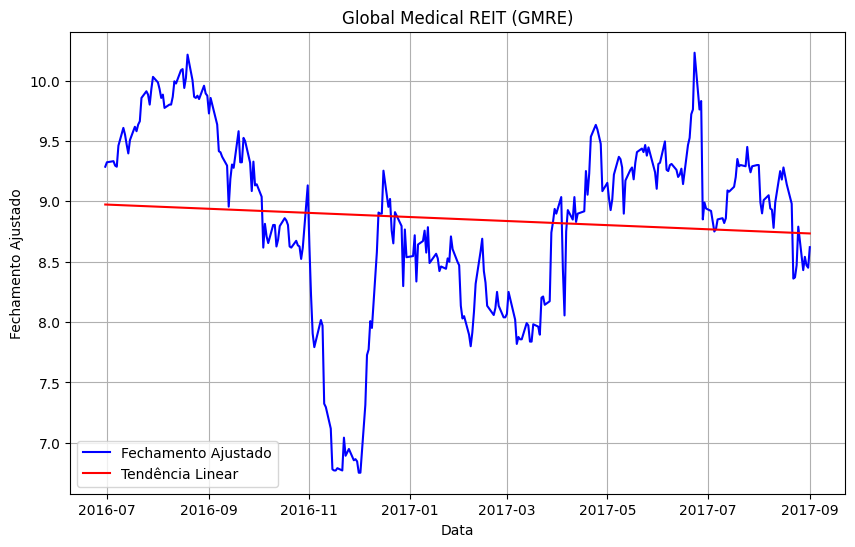

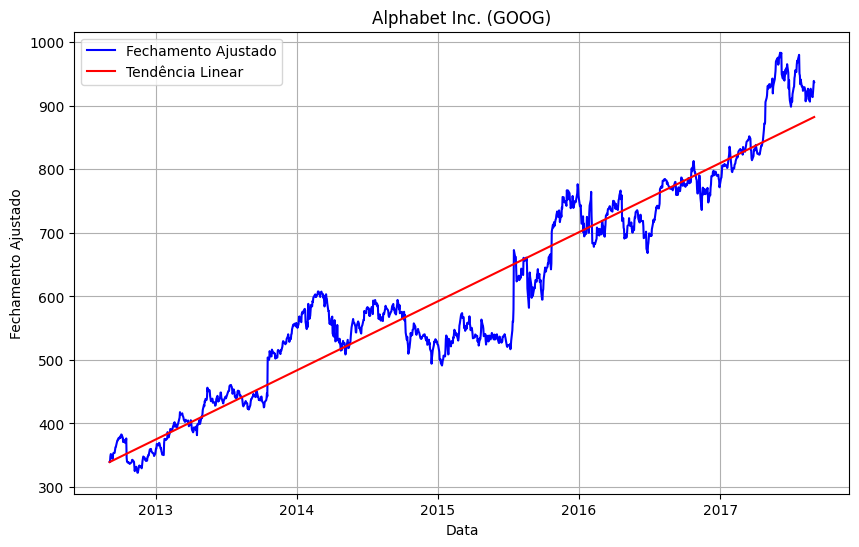

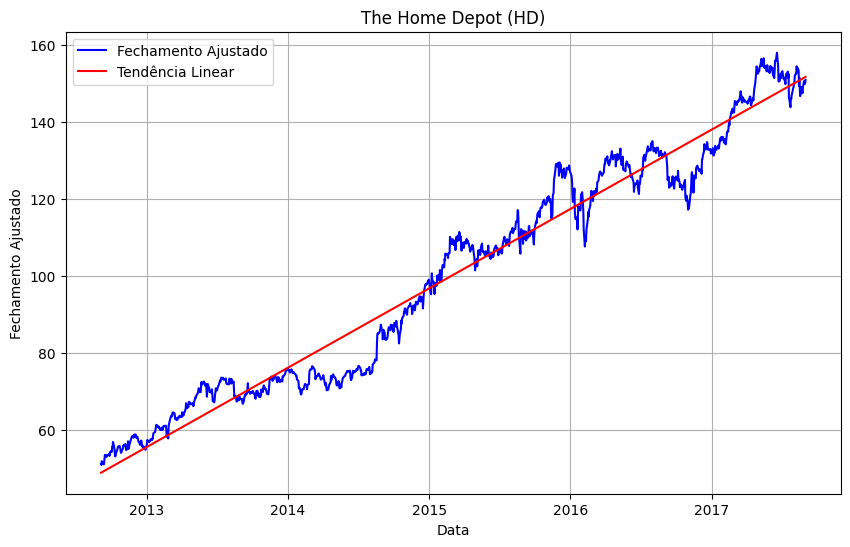

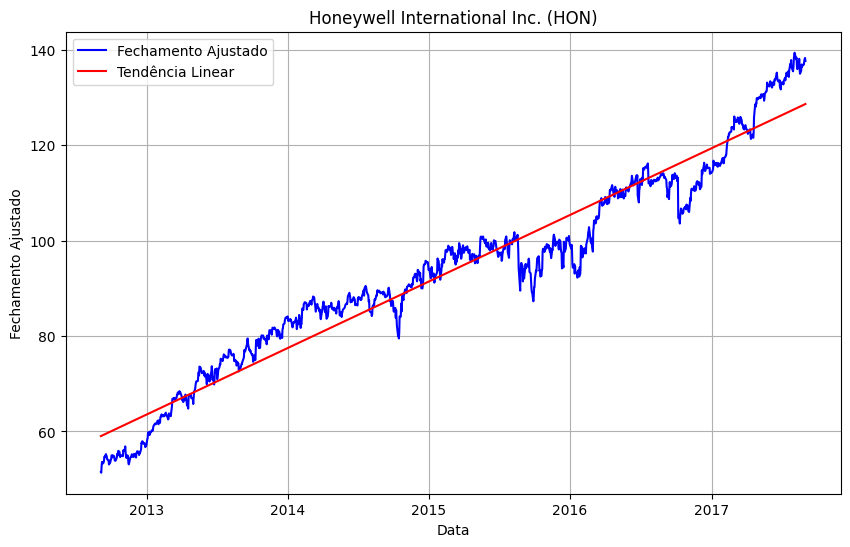

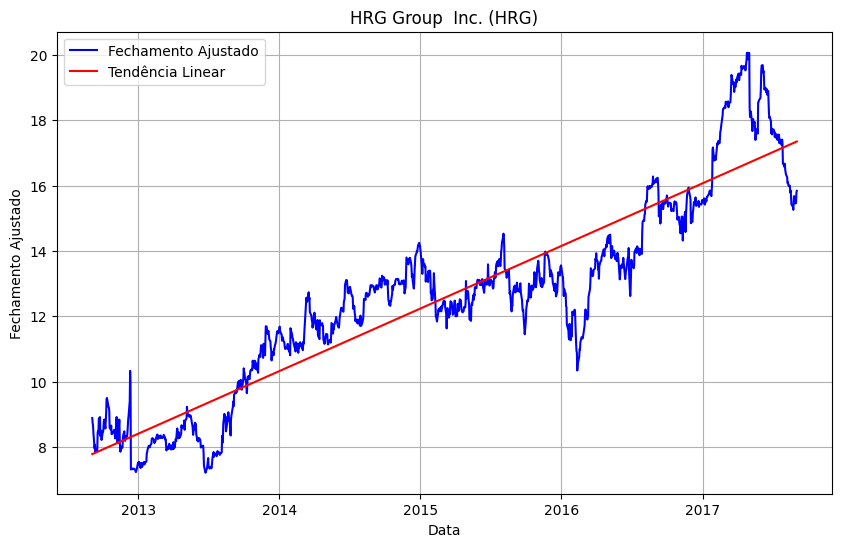

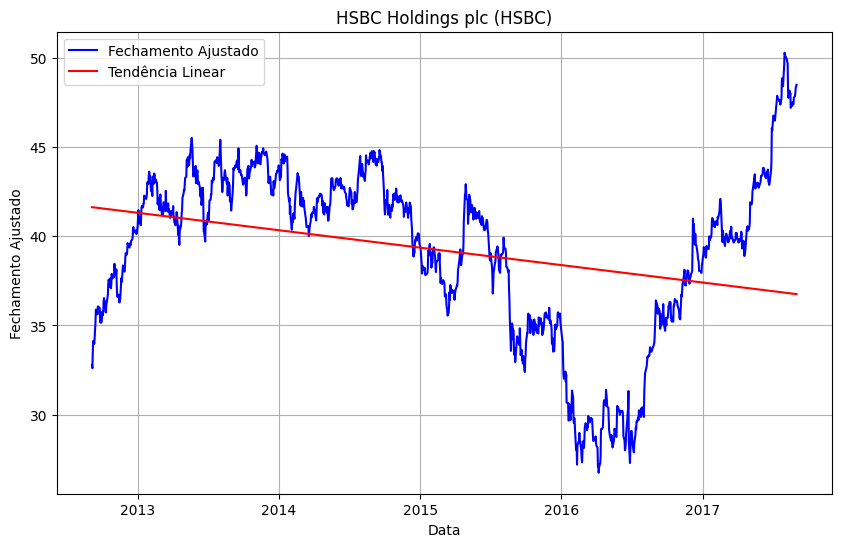

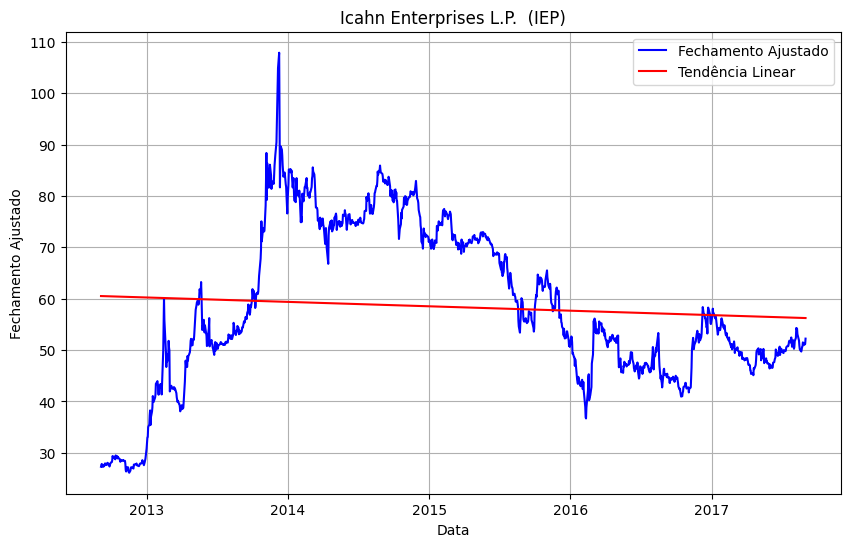

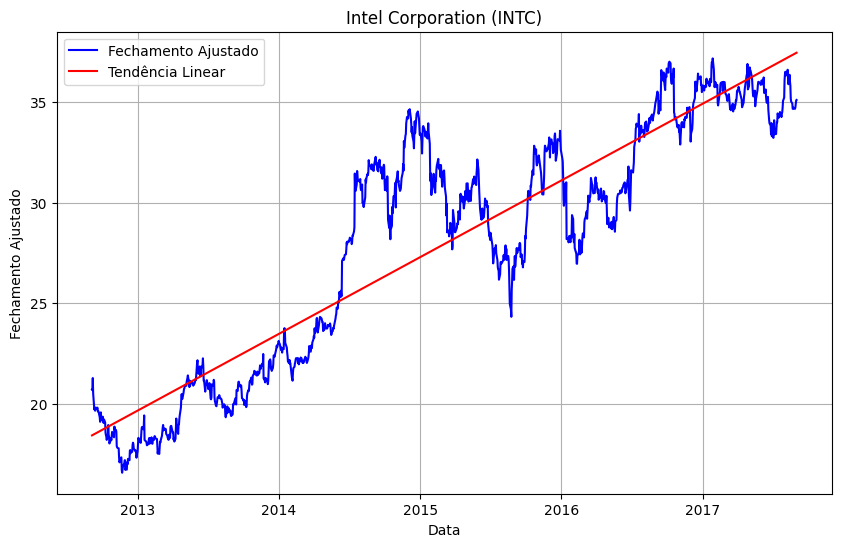

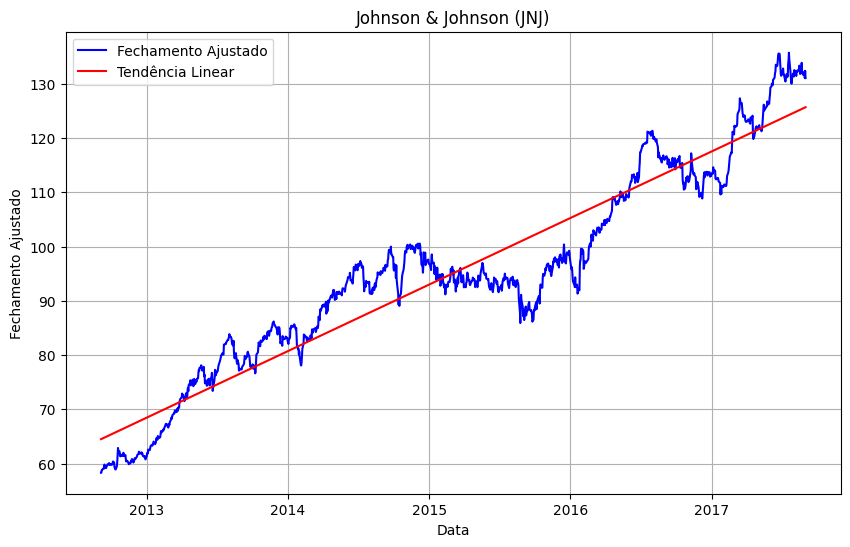

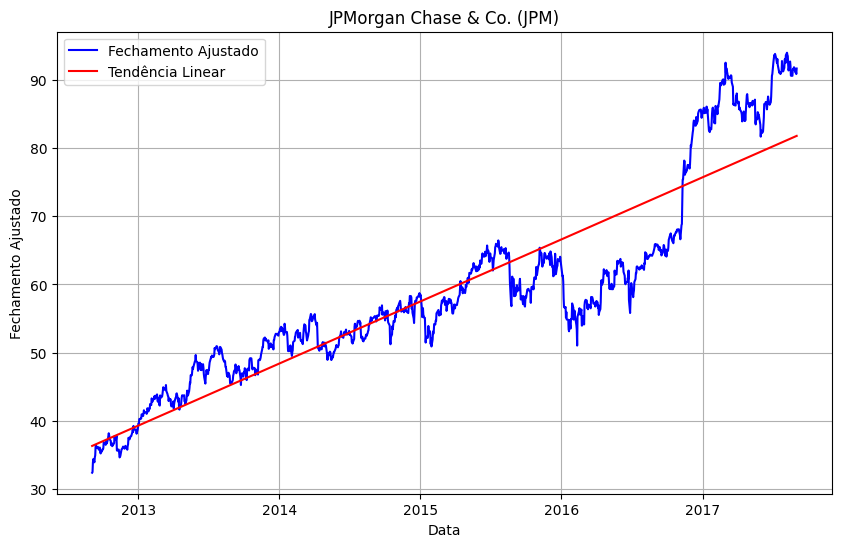

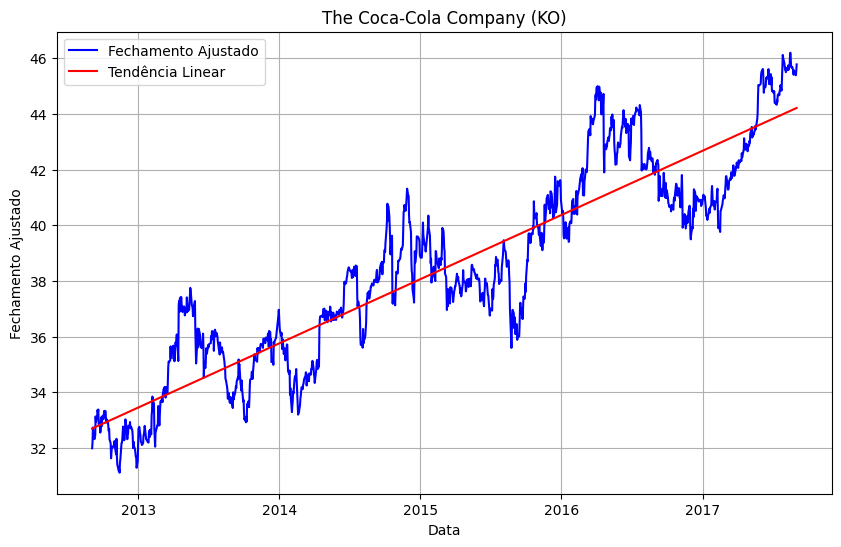

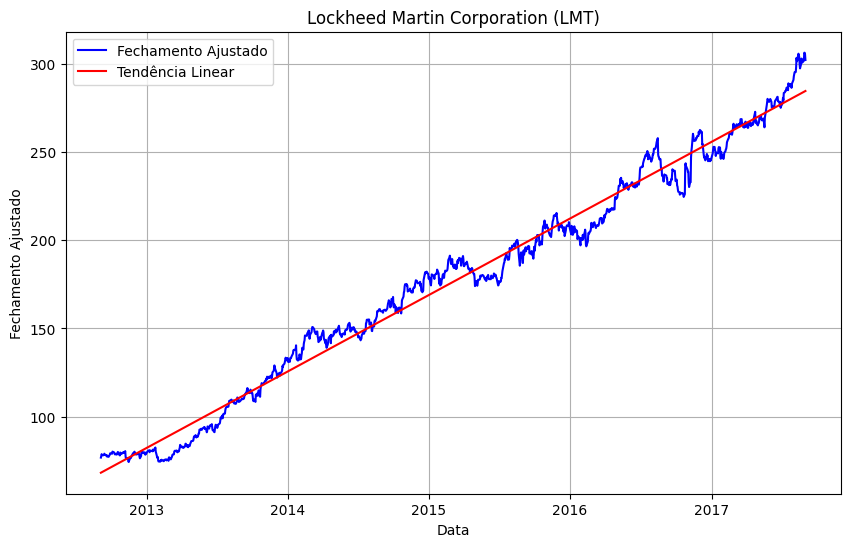

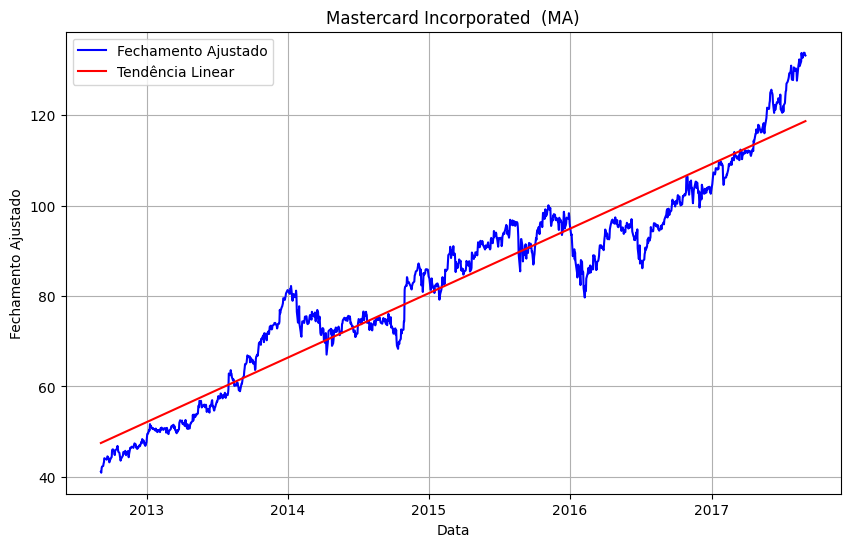

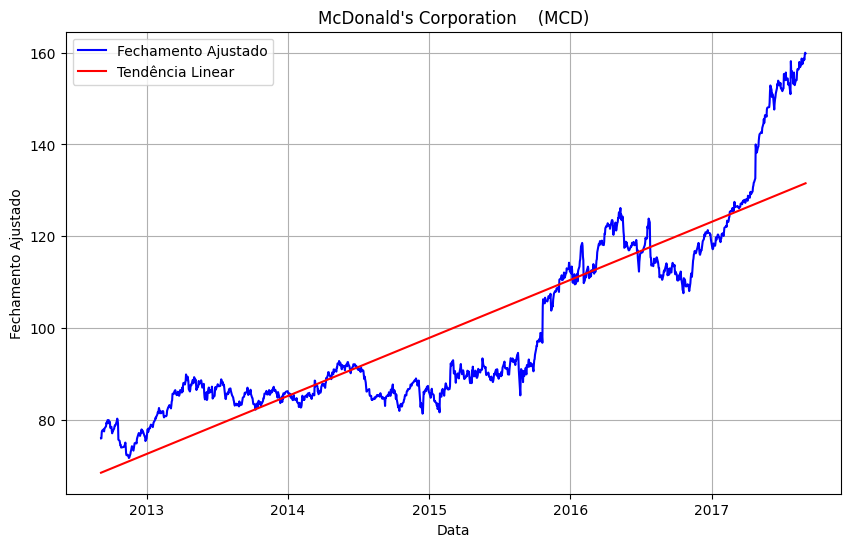

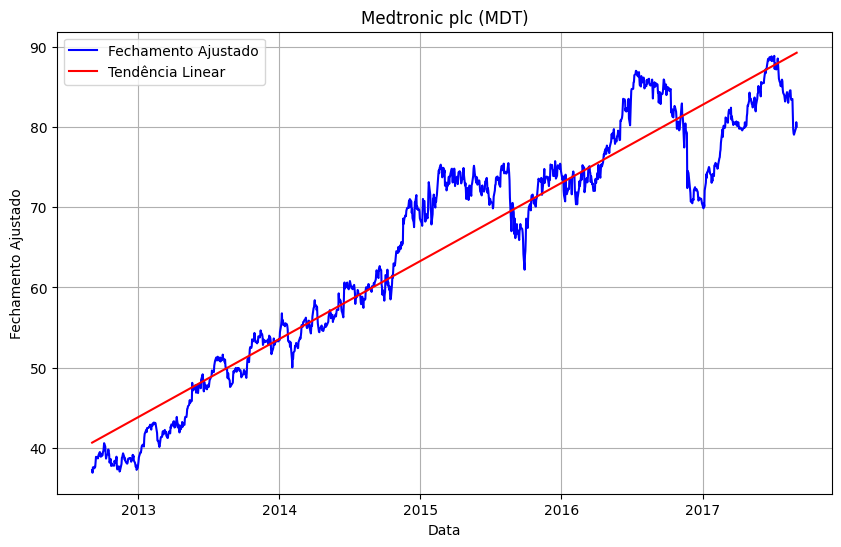

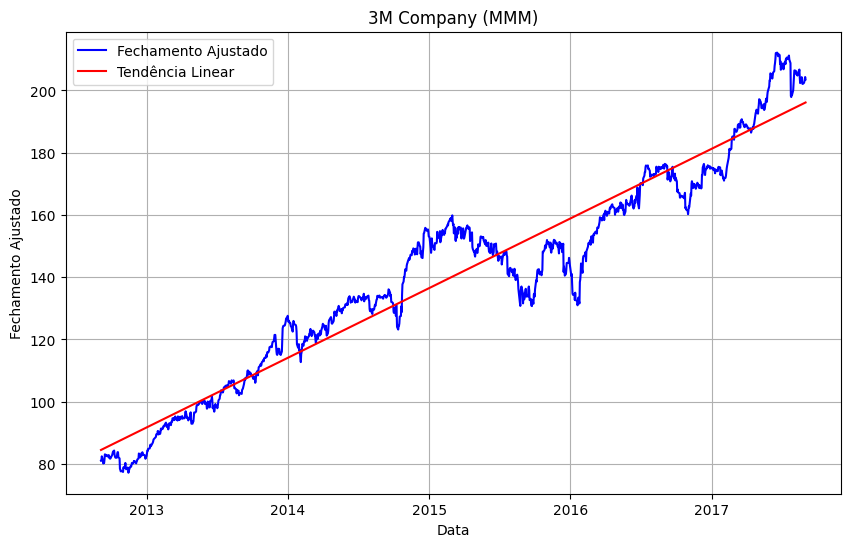

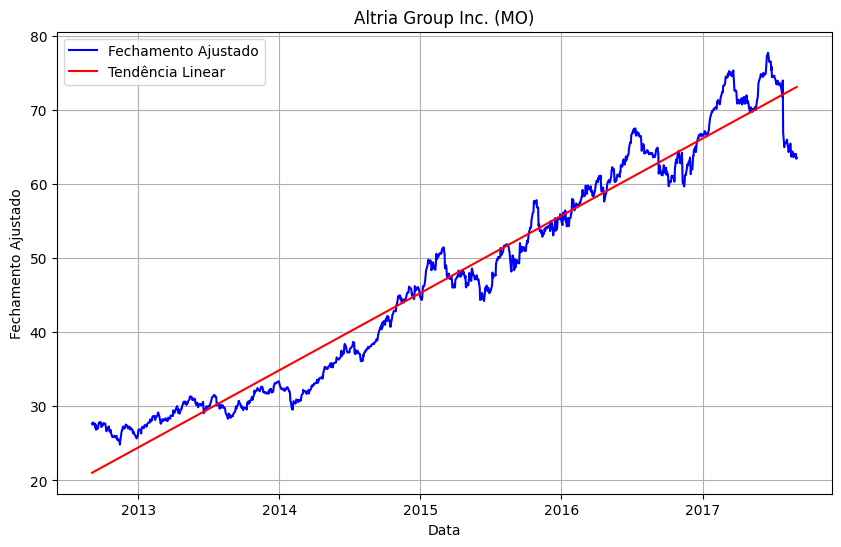

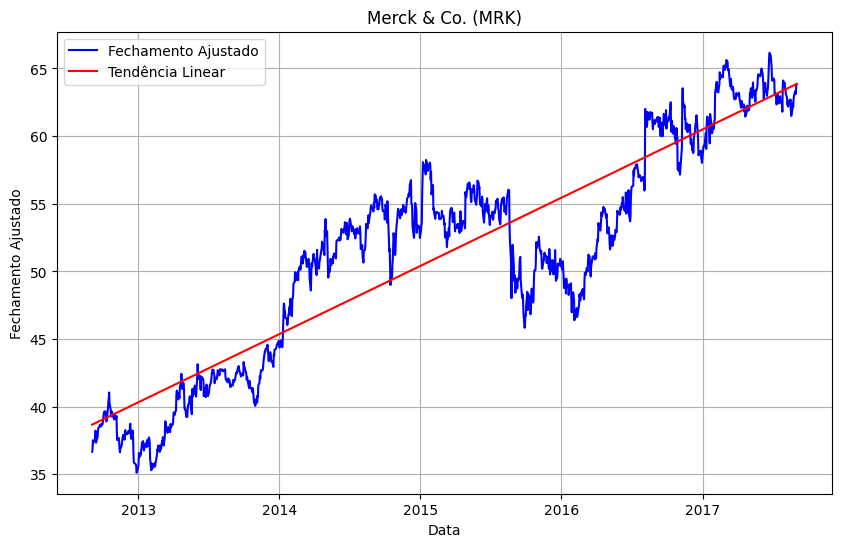

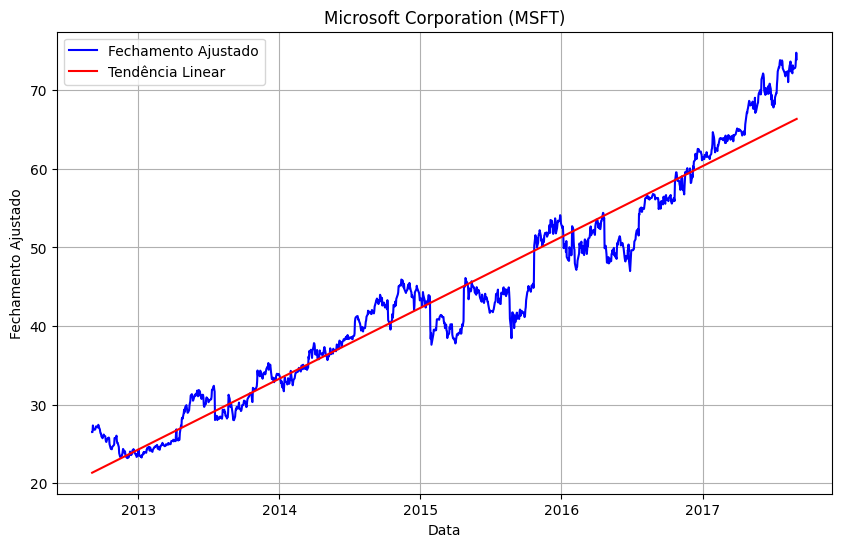

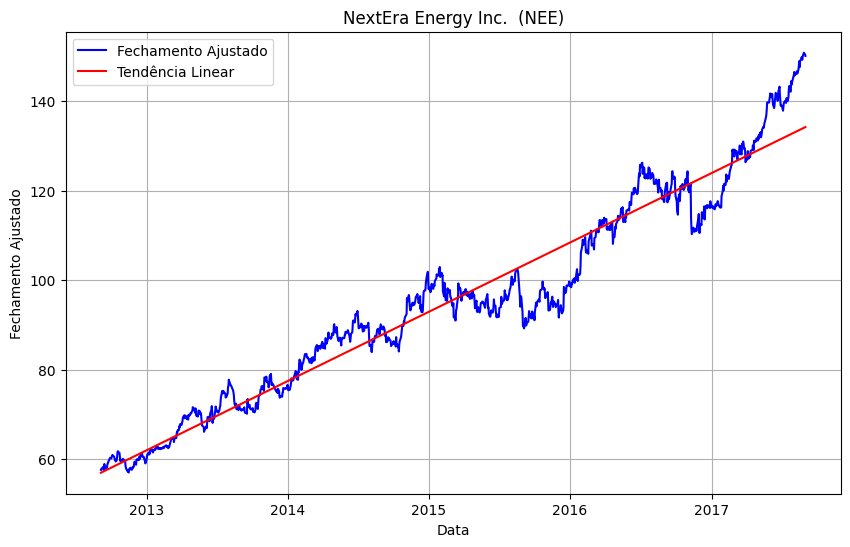

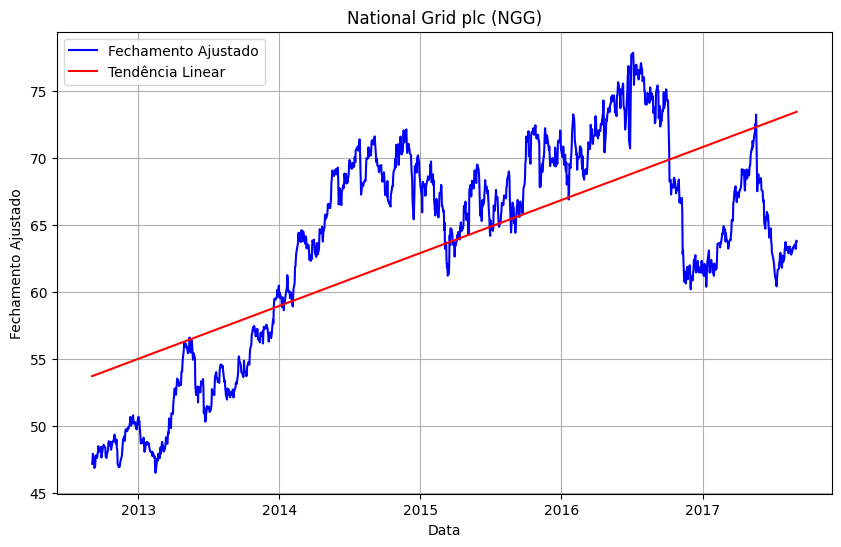

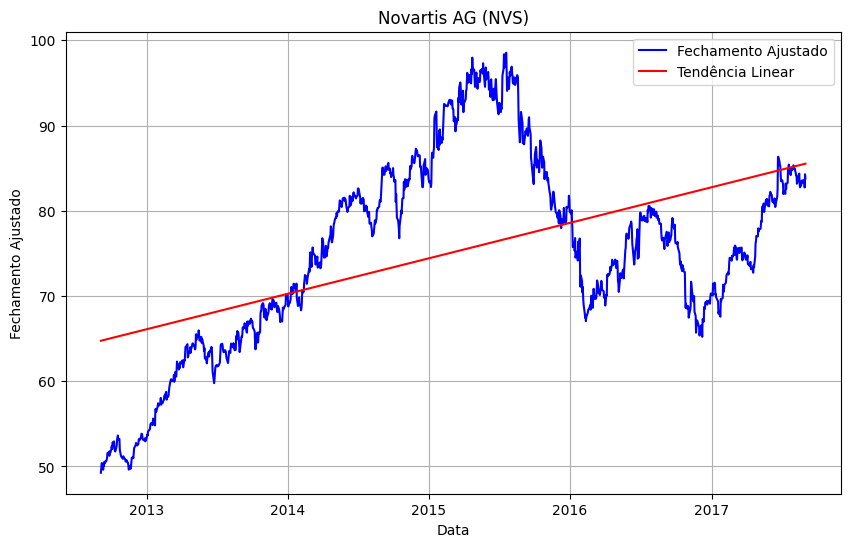

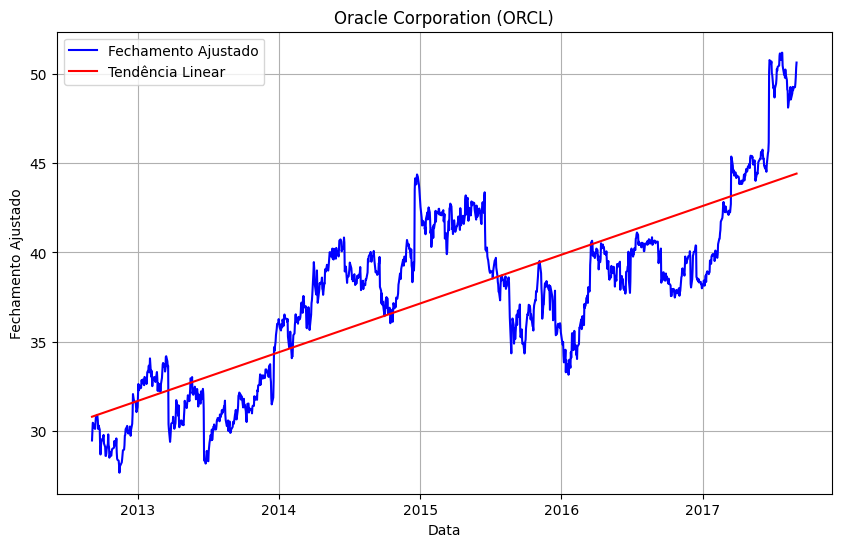

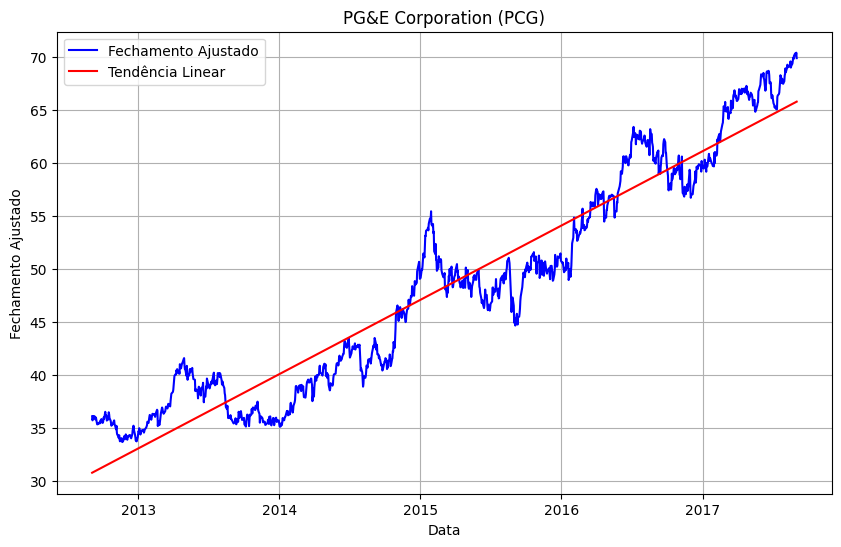

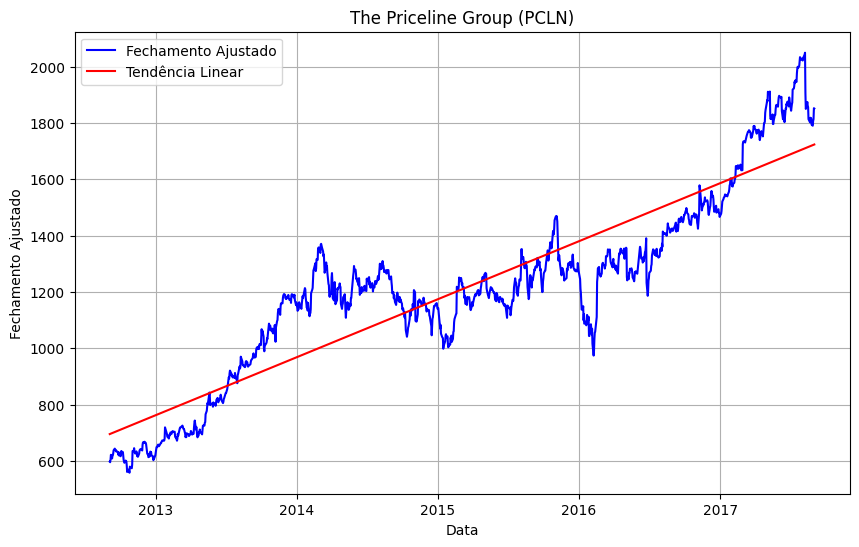

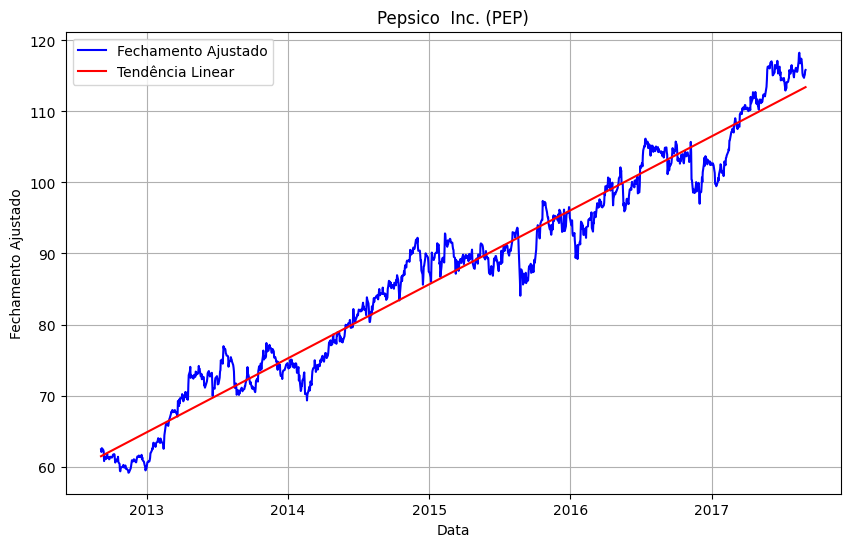

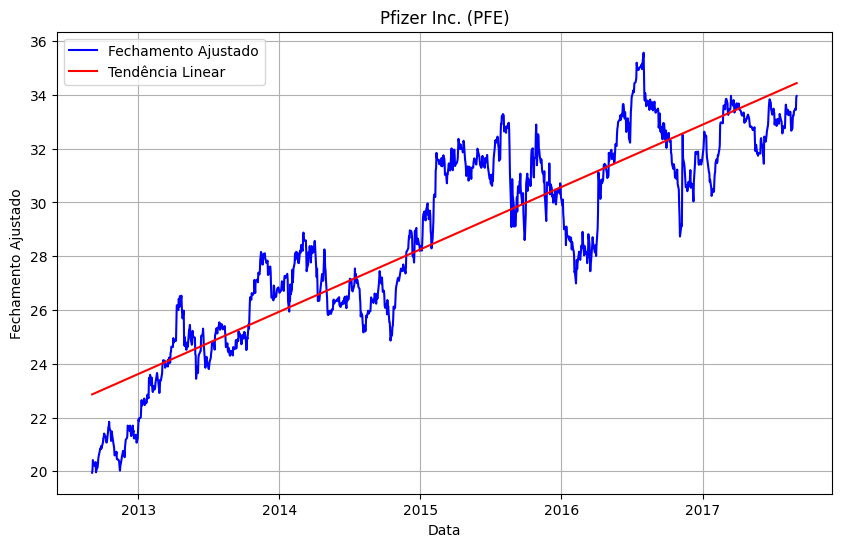

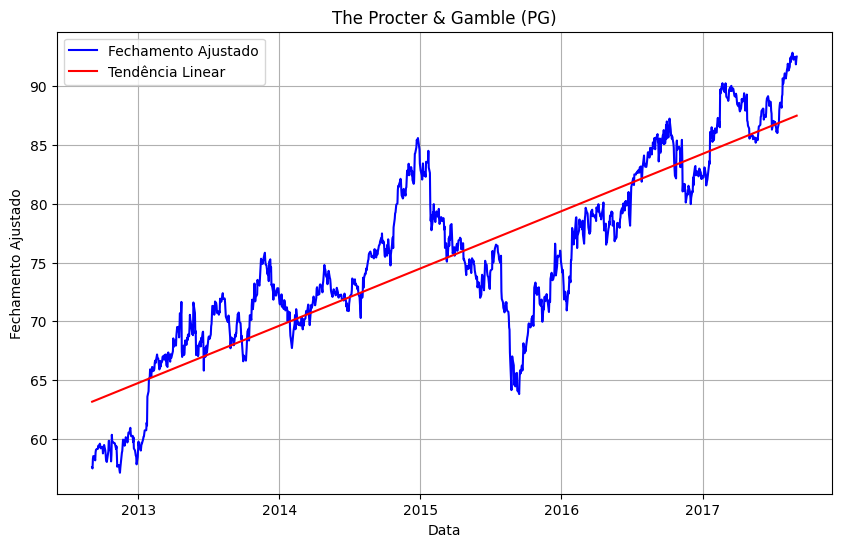

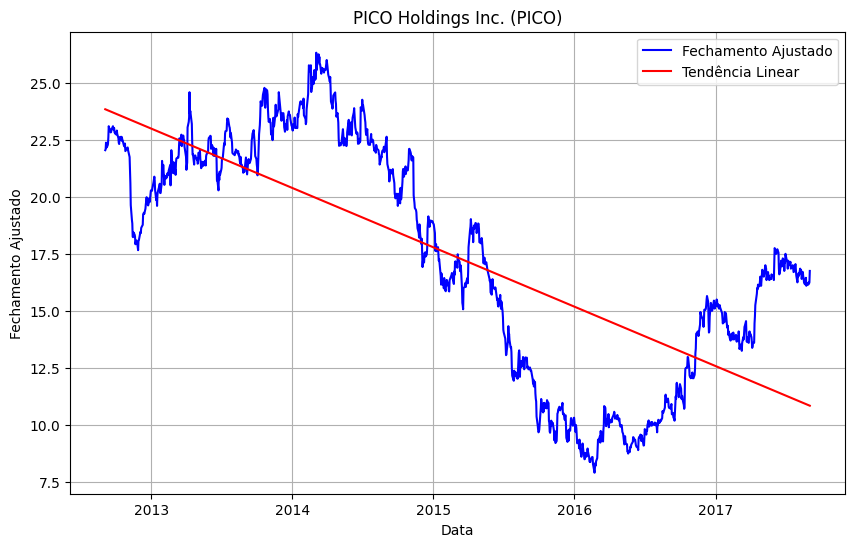

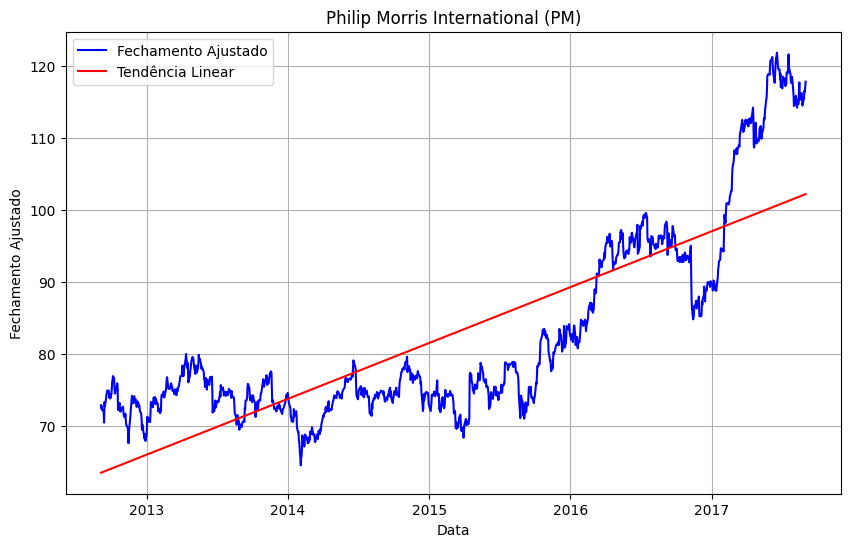

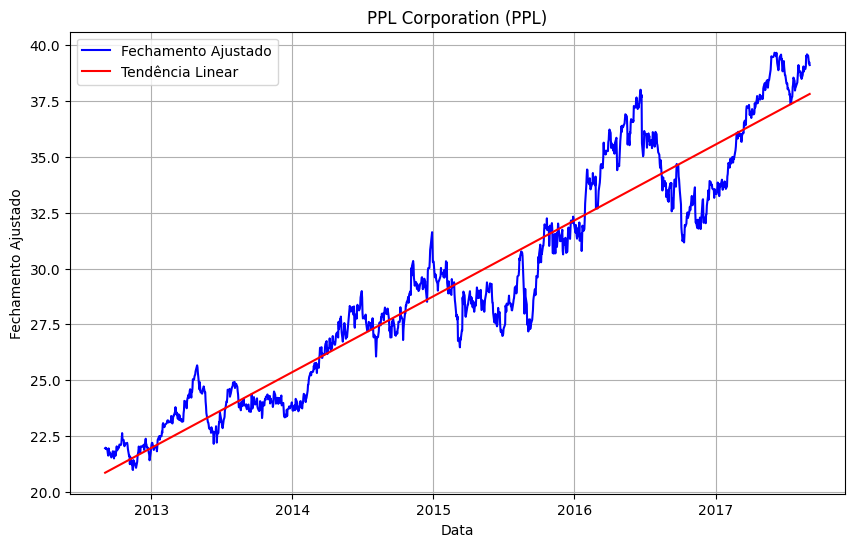

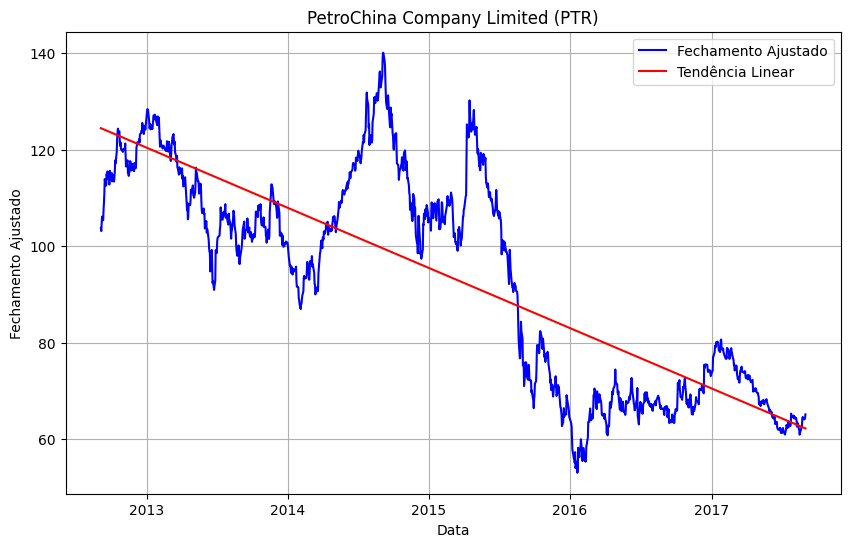

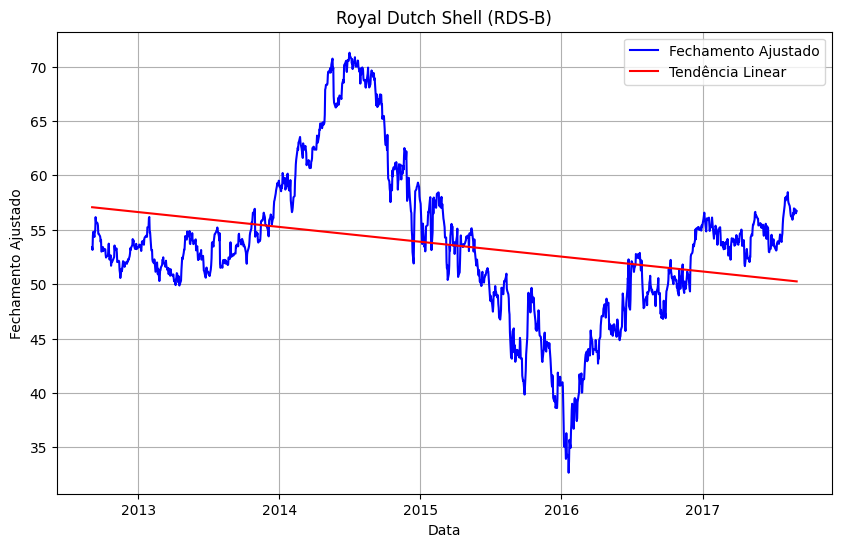

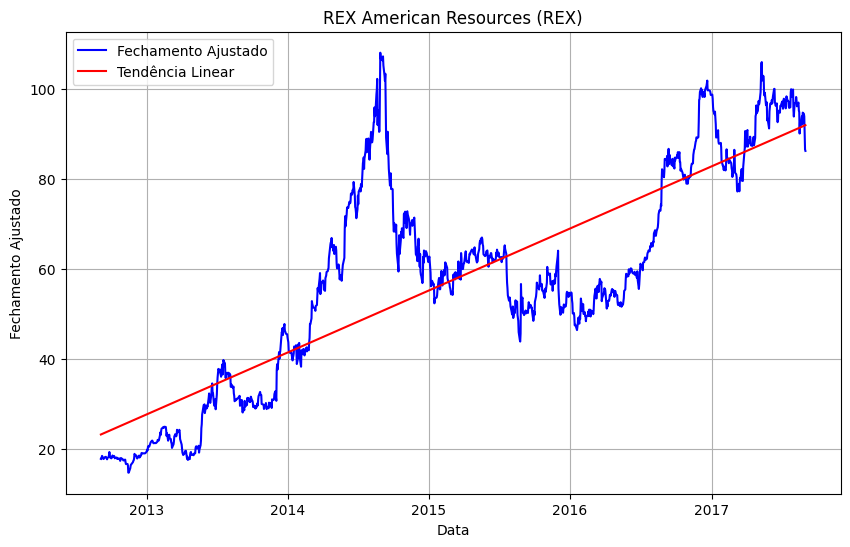

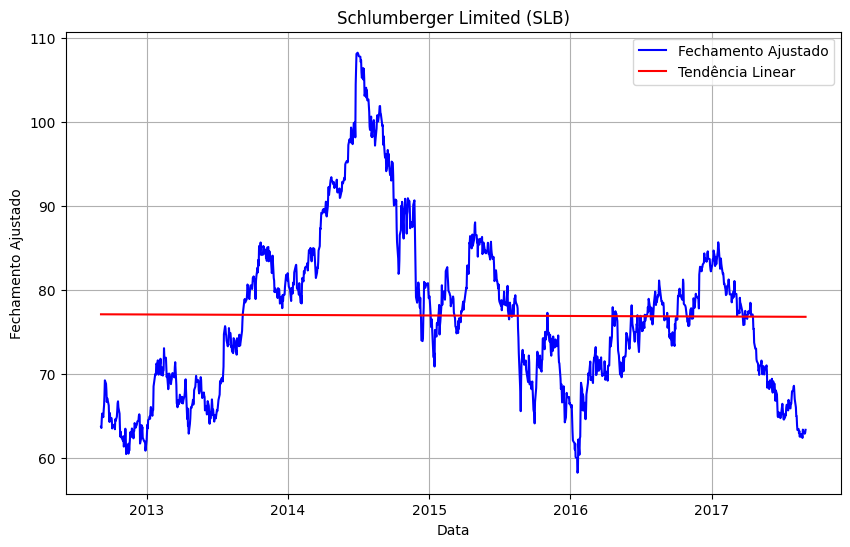

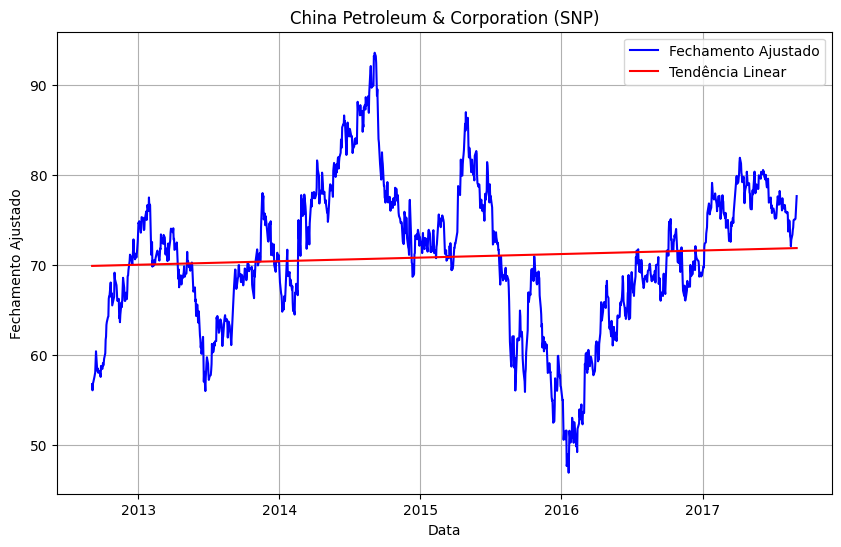

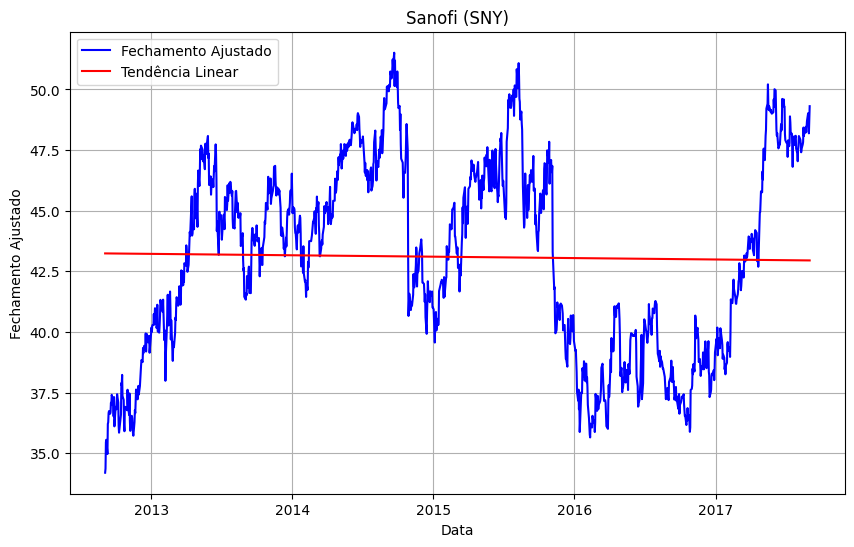

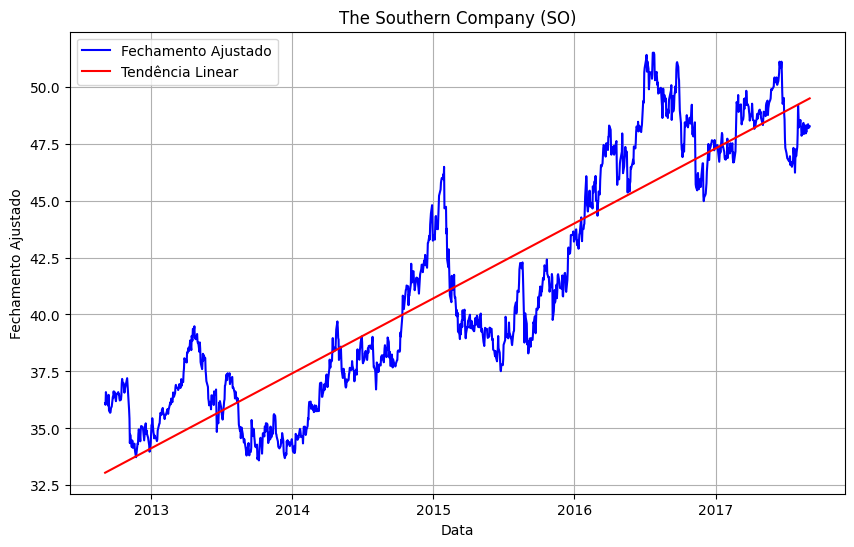

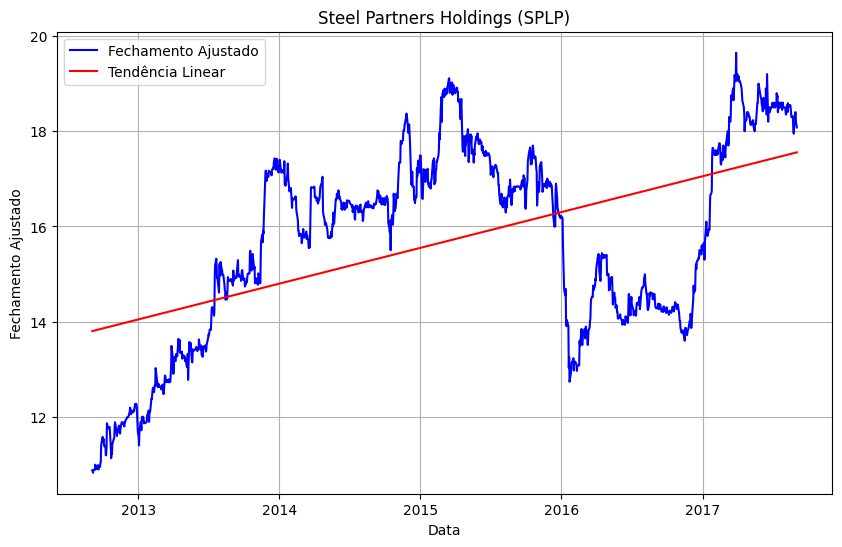

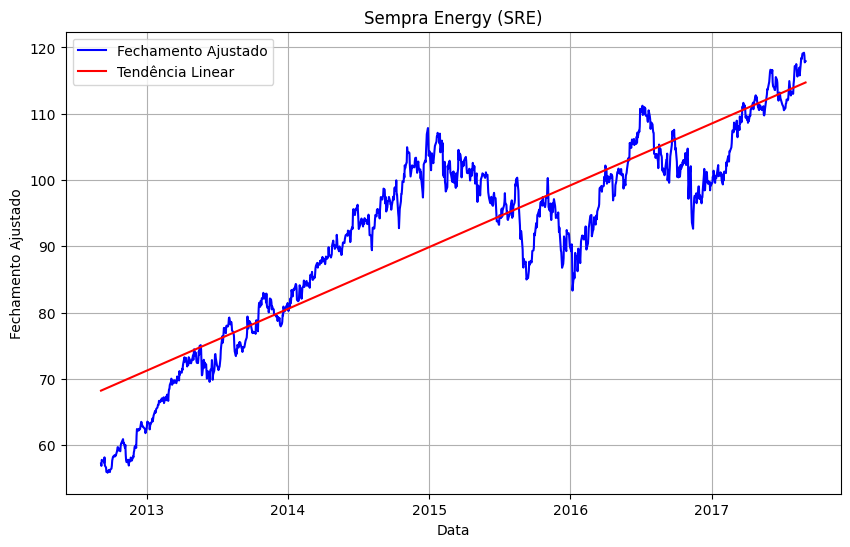

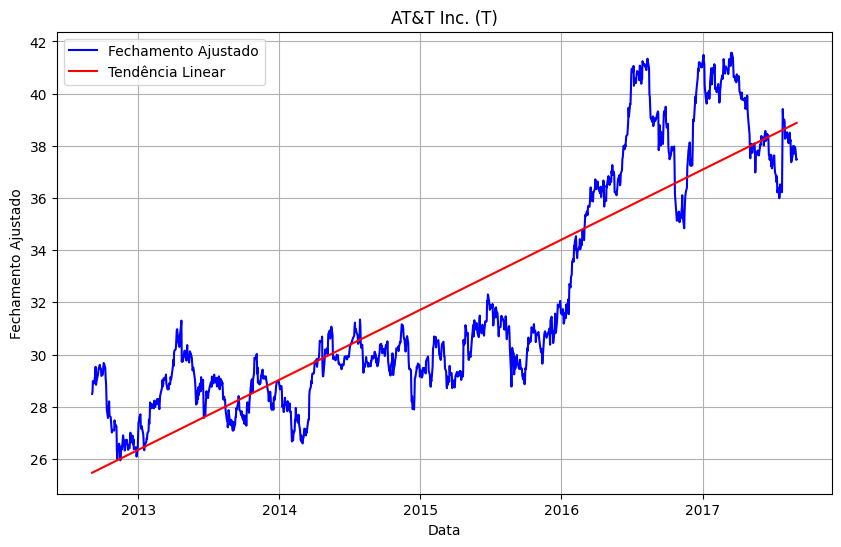

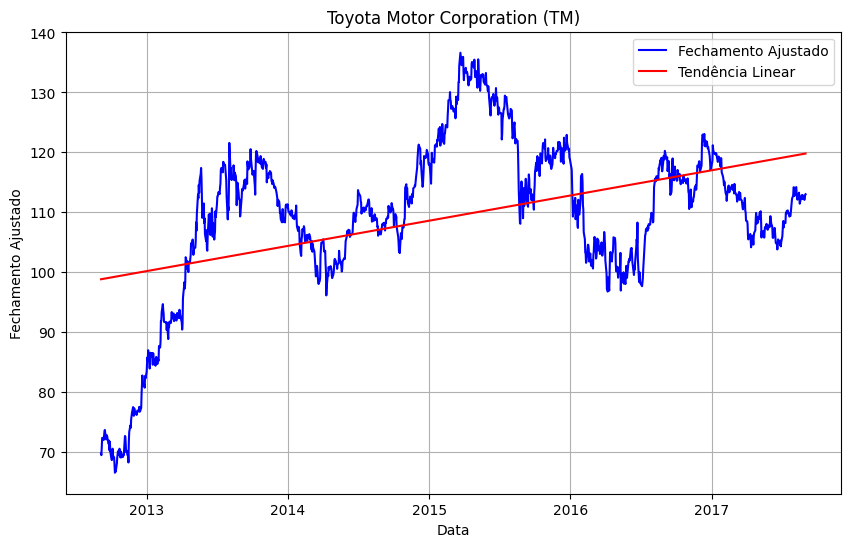

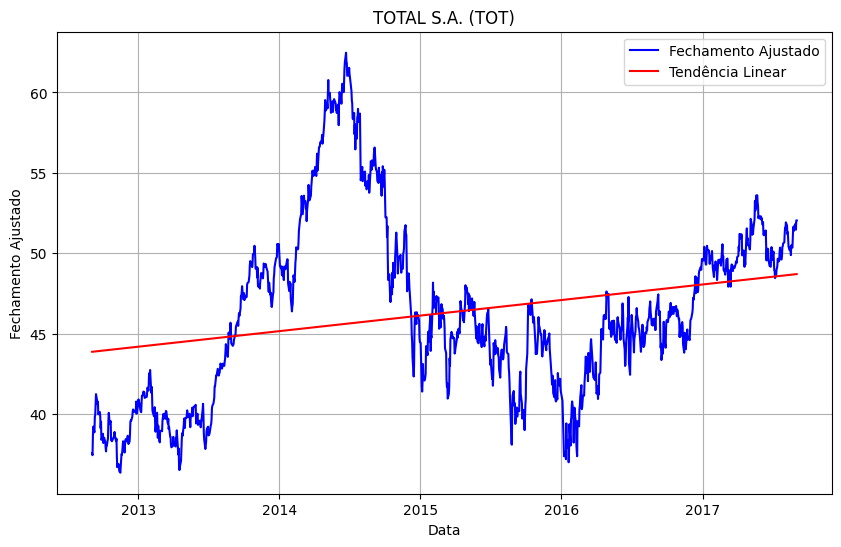

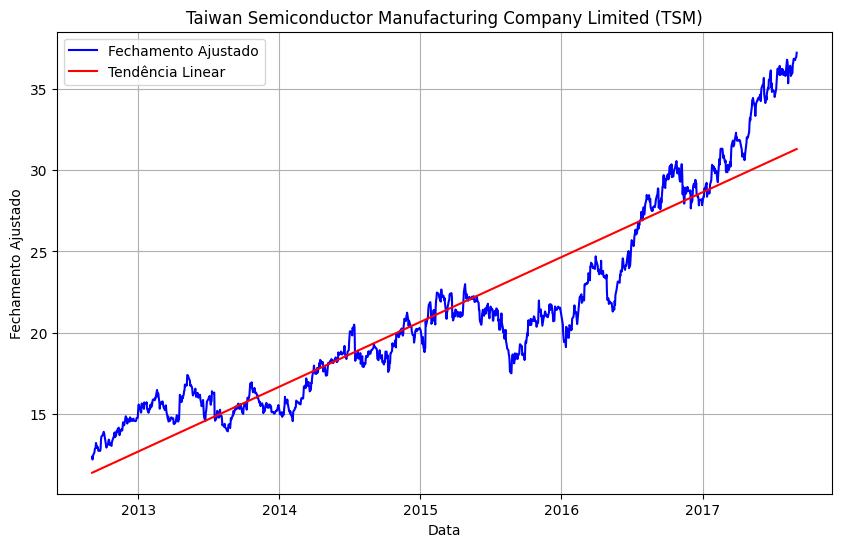

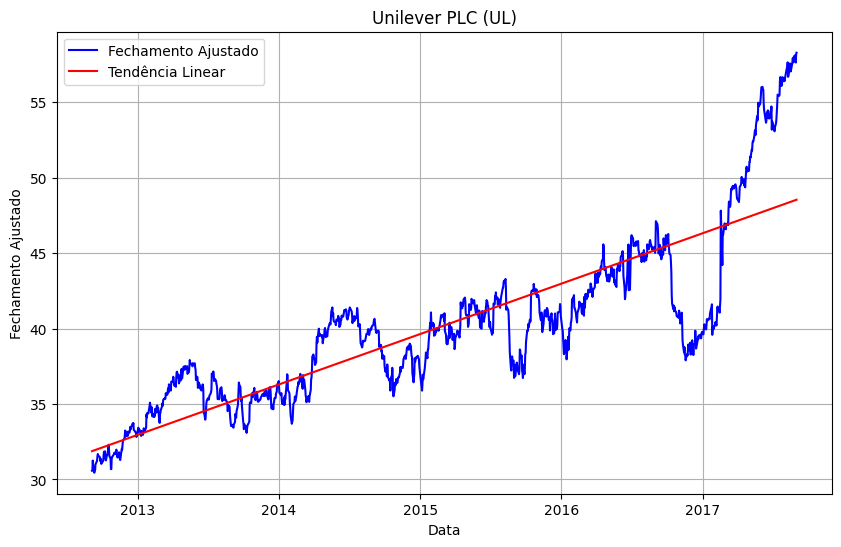

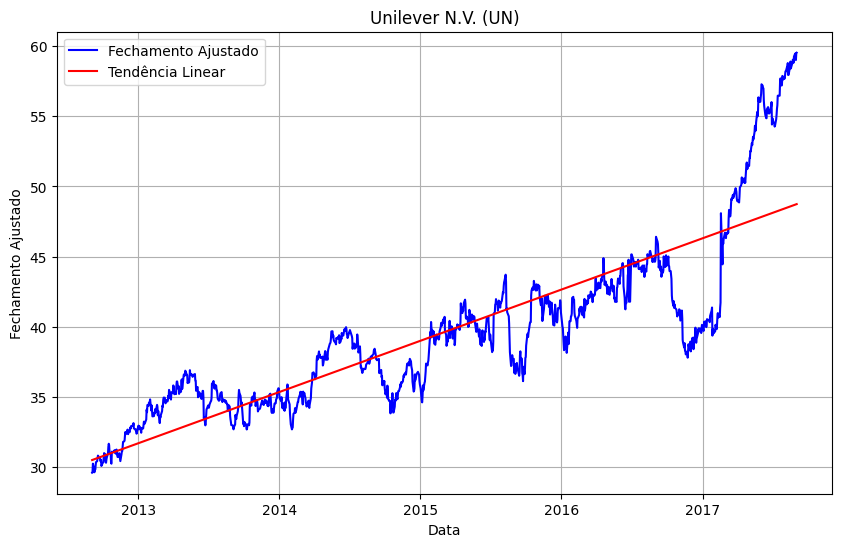

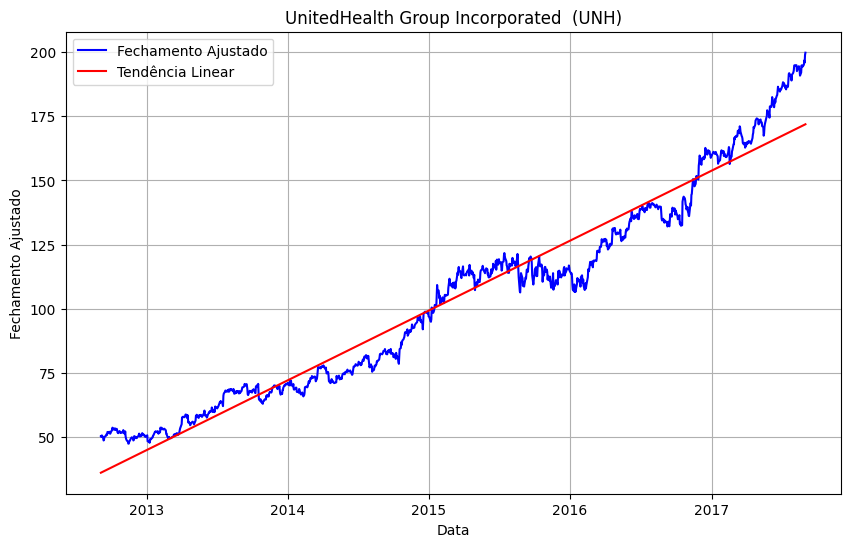

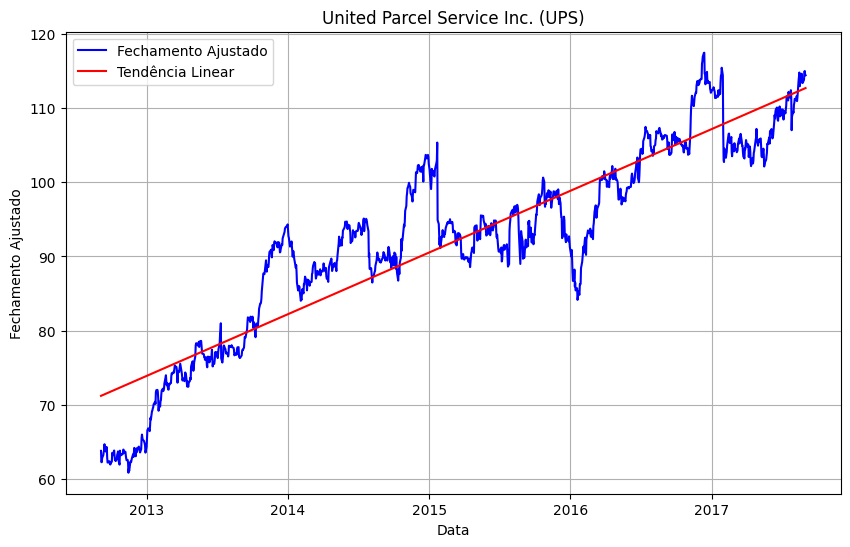

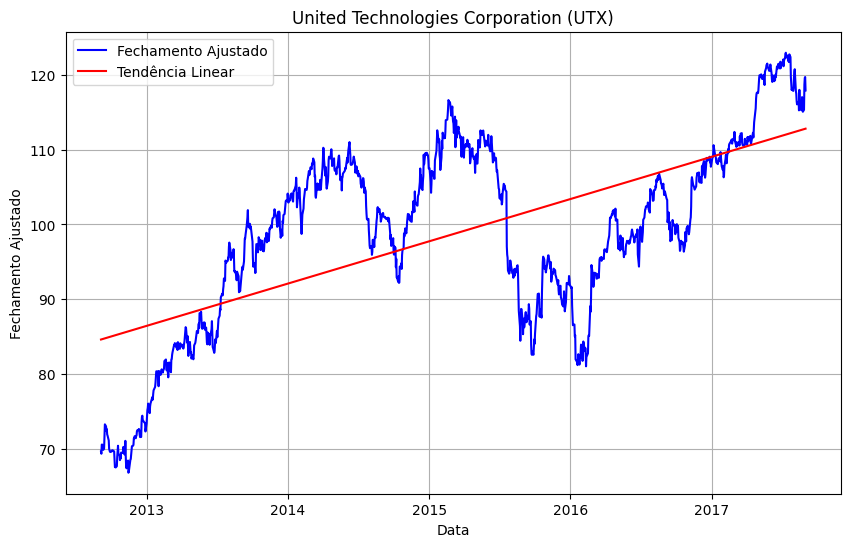

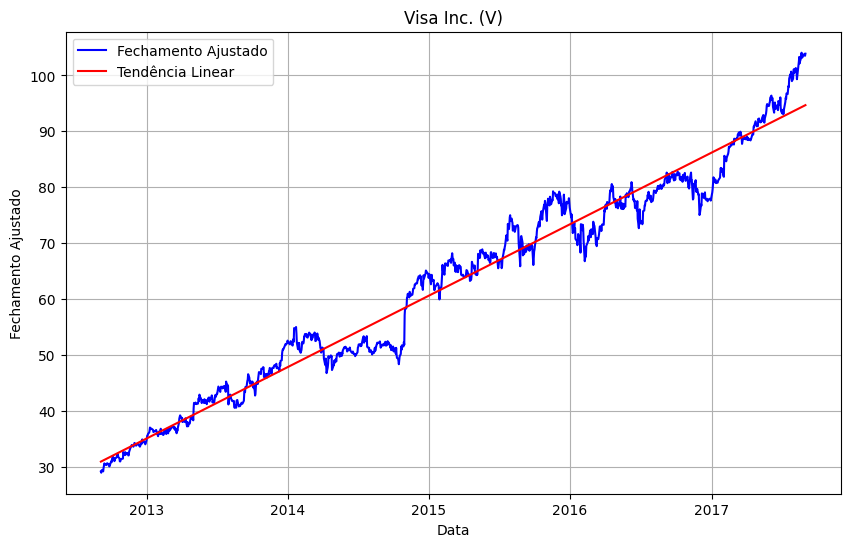

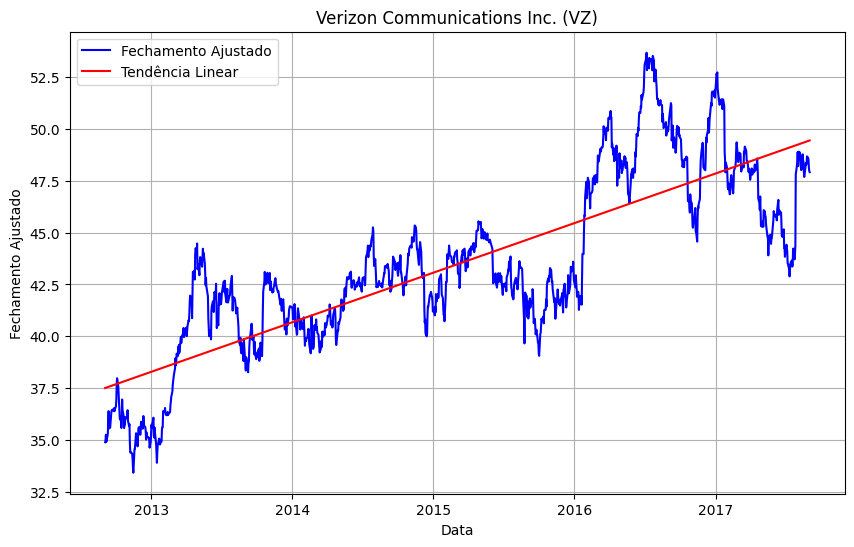

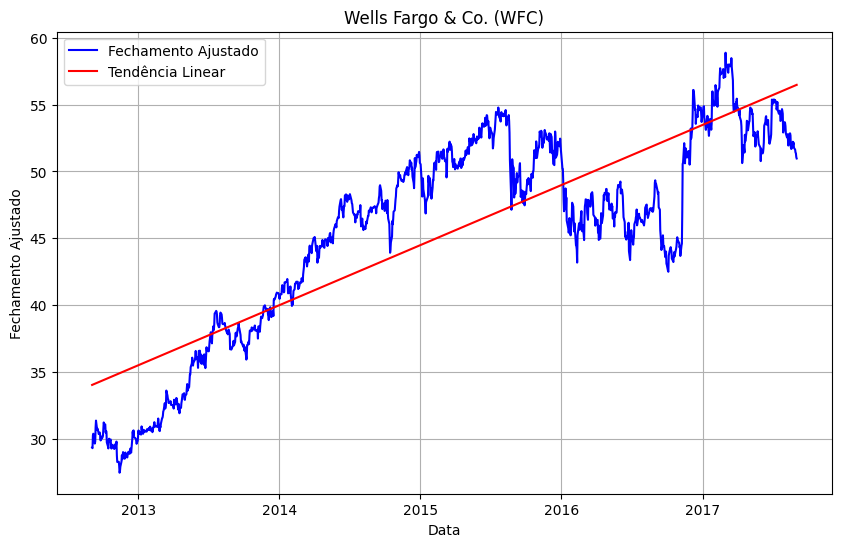

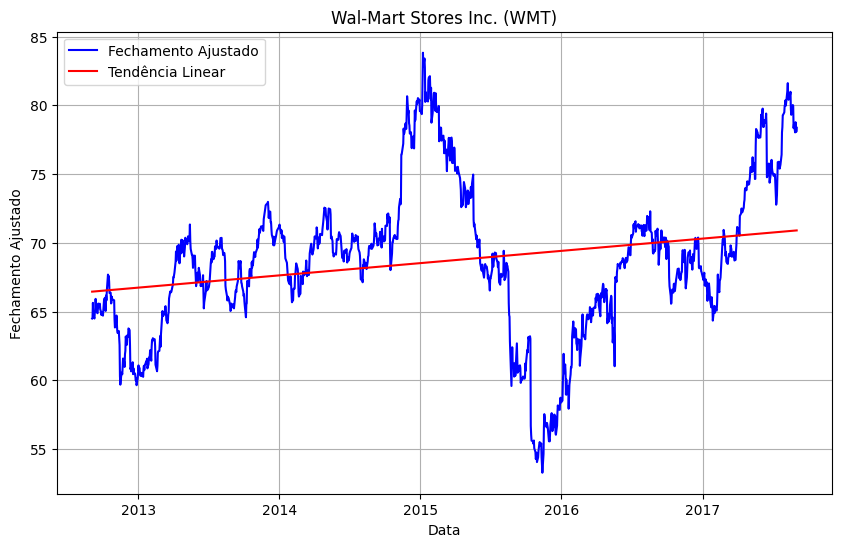

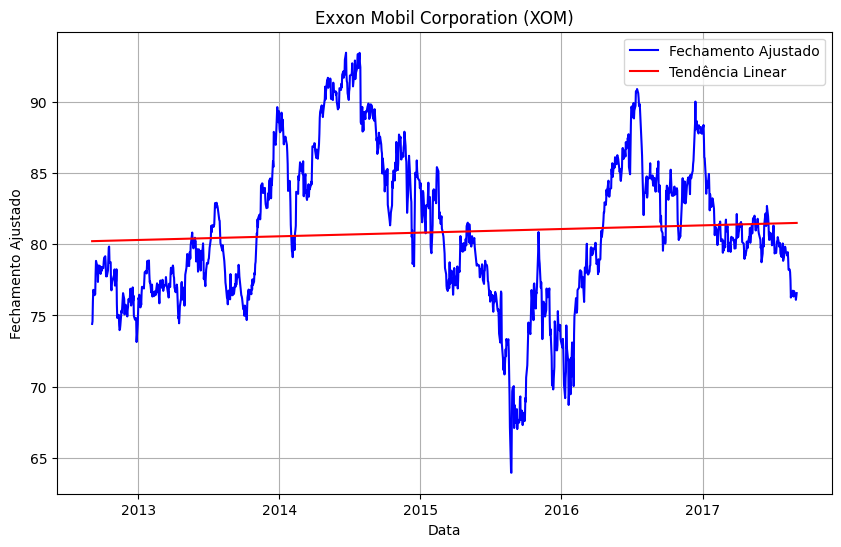

In [2]:
#Código com todas as abordagens para extrair features, para evitar repetição no notebook

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Para guardar os resultados
metrics = []

# Vetores para a 3ª abordagem
vectors = []

# Para caso a coluna não tenha sido reconhecida como datetime
data['Date'] = pd.to_datetime(data['Date'])

# Pega tudo de uma ação por vez
for stock, group in data.groupby('Stock'):
    #Busca no arquivo de setores o setor e o nome completo da empresa
    setor = sectors.loc[sectors['Symbol'] == stock, 'Sector'].values[0]
    nome = sectors.loc[sectors['Symbol'] == stock, 'Company'].values[0]

    #1ª Abordagem
    #Codigo tirado do trabalho original do Fernandez, com a diferença que não é multiplicado pelo numero de dias no ano para obter o valor anualizado
    group['pct_change'] = group['Adj Close'].pct_change()
    retorno = group['pct_change'].mean()
    volatilidade = group['pct_change'].std()

    #2ª Abordagem
    #Precisamos normalizar os valores de fechamento, se não o coeficiente da reta de uma ação com preço USD100 sera maior que a de outra ação com o mesmo cresccimento percentual, porem com valor menor
    #https://www.geeksforgeeks.org/how-to-normalize-data-using-scikit-learn-in-python/
    scaler = MinMaxScaler()
    # Converte a data para um numero inteiro (fonte para o metodo de usar map https://stackoverflow.com/questions/20576618/pandas-datetime-column-to-ordinal)
    X = pd.DataFrame(group['Date'].map(pd.Timestamp.toordinal))
    X = scaler.fit_transform(X)

    y = scaler.fit_transform(pd.DataFrame(group['Adj Close']))

    # aplica a regreção linear
    model = LinearRegression()
    model.fit(X, y)

    # valores previstos pelo modelo para cada data
    y_pred_normalizado = model.predict(X)

    # Reverte a normalização pra ajustar a reta no grafico de preço original
    y_pred = scaler.inverse_transform(y_pred_normalizado)

    # Calcular o MSE do modelo
    mse = mean_squared_error(y, y_pred_normalizado)

    # Para a 3ª abordagem, guarda todos os retornos em uma lista
    vetor = group['pct_change'].tolist()
    vectors.append({"Ativo": stock, "Vetor": vetor})


    # Guarda os resultados como um dict para ficar mais simples de converter em dataframe
    metrics.append({
        'Ativo': stock,
        'Retorno': retorno,
        'Volatilidade': volatilidade,
        'Coeficiente': model.coef_[0][0],
        'MSE': mse,
        'Setor': setor,
        'Nome': nome
    })

    # Gera e armazena graficos do preço ajustado de cada ação com sua respectiva tendencia
    plt.figure(figsize=(10, 6))
    plt.plot(group['Date'], group['Adj Close'], label='Fechamento Ajustado', color='blue')
    plt.plot(group['Date'], y_pred, label='Tendência Linear', color='red')
    plt.title(f'{nome} ({stock})')
    plt.xlabel('Data')
    plt.ylabel('Fechamento Ajustado')
    plt.legend()
    plt.grid(True)
    plt.savefig(stock + '.png')


# Create a DataFrame with the regression results
results_df = pd.DataFrame(metrics)

Inicialmente partimos do trabalho prévio de [Facundo Joel Allia Fernandez (2022)](https://ssrn.com/abstract=4403662), replicando uma de suas tecnicas e experimentamos 2 novas distintas para extração de features do conjunto de dados, então aplicando Clustering e realizando uma analise qualitativa dos resultados.

### 1. Retorno médio e Volatilidade
Para a primeira abordagem de extração de *features*, reproduzimos parte do método descrito por **Fernandez**. Diferentemente do estudo de Fernandez, optamos por utilizar o **retorno diário médio** em vez do anualizado. As métricas selecionadas foram calculadas para cada ativo e representadas graficamente em um espaço bidimensional.

Para identificar clusters de ações com características semelhantes utilizamos os algoritmos *k-means* e *agrupamento aglomerativo hierárquico*, por estarem descritos na seção "*Clustering*" do livro [Probabilistic Machine Learning](https://probml.github.io/pml-book/book1.html), em suas implementações da biblioteca [scikit-learn](https://scikit-learn.org/). Abaixo detalhamos as métricas utilizadas:

- **Retorno Médio**: Calculado como a média simples dos valores de variação percentual entre dias consecutivos no preço de fechamento ajustado.
- **Volatilidade**: Representada pelo desvio padrão do retorno médio, indicando a instabilidade associada ao ativo.

Ambos os algoritmos foram configurados para gerar 5 clusters, escolhidos arbitrariamente com a ideia de representar uma classificação qualitativa de 1 a 5 em relação ao risco e retorno das ações, sendo 5 atribuído a ativos com baixa volatilidade e alto retorno.


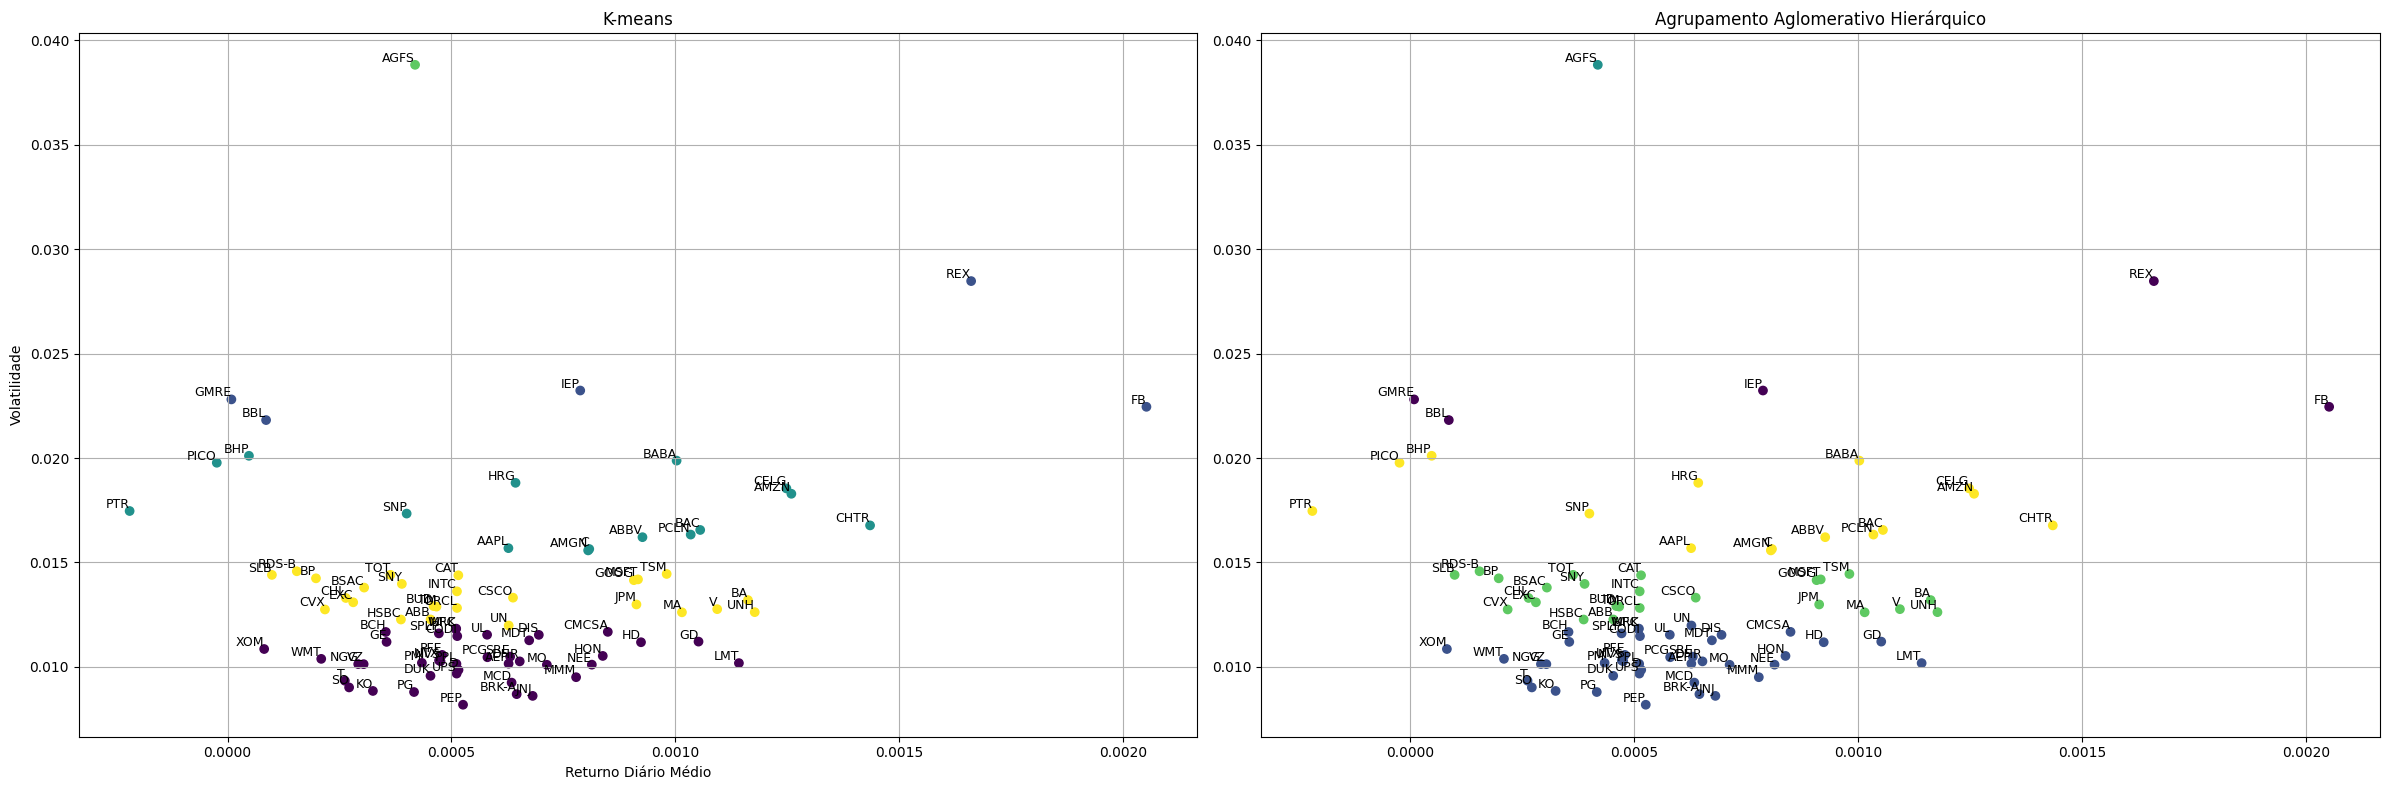

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering

X_trad = results_df[['Retorno', 'Volatilidade']]

#Kmean utiliza aleatoriedade, então, para ter resultados iguais em outra execução, um numero para o random_state deve ser definido
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_trad)
results_df['trad_Kmean_Cluster'] = kmeans.labels_

hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(X_trad)
results_df['trad_Hierarchical_Cluster'] = hierarchical_labels

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.scatter(results_df['Retorno'], results_df['Volatilidade'], c=results_df['trad_Kmean_Cluster'], cmap='viridis', marker='o')
plt.xlabel('Returno Diário Médio')
plt.ylabel('Volatilidade')
plt.title("K-means")
plt.grid(True)
for i, row in results_df.iterrows():
    plt.text(row['Retorno'], row['Volatilidade'], row['Ativo'], fontsize=9, ha='right', va='bottom')

plt.subplot(1, 2, 2)

plt.scatter(results_df['Retorno'], results_df['Volatilidade'], c=results_df['trad_Hierarchical_Cluster'], cmap='viridis', marker='o')
plt.title('Agrupamento Aglomerativo Hierárquico')
plt.grid(True)
for i, row in results_df.iterrows():
    plt.text(row['Retorno'], row['Volatilidade'], row['Ativo'], fontsize=9, ha='right', va='bottom')

plt.tight_layout()
plt.show()

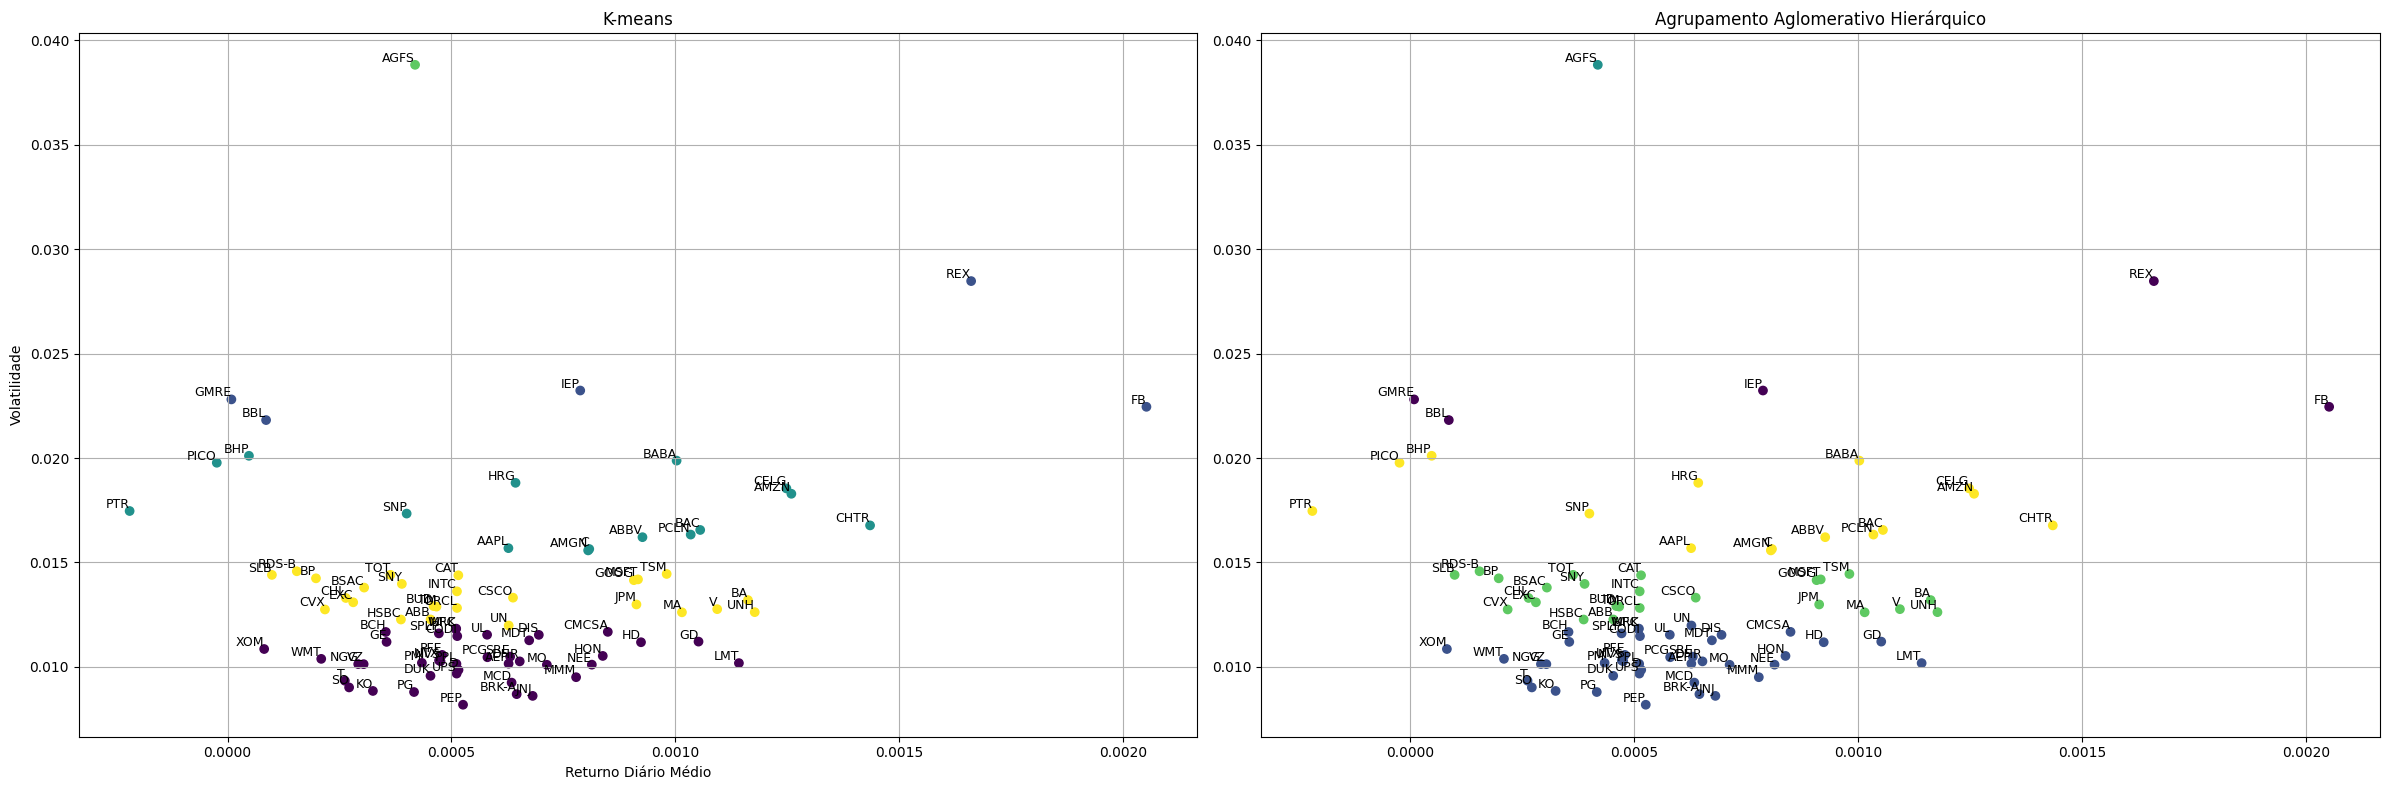

Ao aplicar os algoritmos, observamos que os clusters formados estavam majoritariamente influenciados pela **volatilidade** das ações, mais do que pelo retorno diário médio. Ao todo, o resultado cumpre o esperado ao identificar um grupo de ações mais "seguras", caracterizado por baixa volatilidade e retorno moderado, com grupos de ativos com retornos mais altos apresentando maior volatilidade.

Essa relação entre risco e retorno reforça a importância da diversificação. A abordagem identificou grupos que podem ser utilizados estrategicamente para criar portfólios mais equilibrados, com combinações de ações de diferentes níveis de volatilidade.

Adicionalmente, foi notável que ambos os algoritmos, *k-means* e *agrupamento hierárquico*, produziram resultados praticamente idênticos nesta abordagem. Isso sugere que, para este conjunto de dados e métricas, ambos os métodos podem ser considerados intercambiáveis.

---



Decidimos também experimentar uma nova estrategia para gerar as features a partir dos dados: ajustar uma reta de tendência ao histórico de preços de cada ação.

### 2. Coeficiente e Erro Médio Quadrático (MSE) da Tendência Linear

A regressão linear, embora seja um modelo simples demais para descrever o comportamento de ativos do mercado financeiro, pode ser útil ao informar sobre a taxa de crescimento consistente de uma ação, mesmo sem representar fielmente todas as nuances do mercado. A partir desse modelo, utilizamos duas métricas principais como *features*:

- **Coeficiente da Reta**: Representa a inclinação da tendência linear e indica a taxa de crescimento do preço da ação. Valores positivos sugerem crescimento consistente, enquanto valores negativos indicam uma tendência de queda.
- **Erro Médio Quadrático (MSE)**: Mede a discrepância entre os valores originais e a linha de tendência ajustada. Um MSE maior reflete maior variabilidade nos preços em relação à tendência estimada, indicando maior instabilidade. O MSE, por elevar o erro ao quadrado, pune mais discrapancias maiores. Dessa forma, ações que apresentaram alta volatilidade nos preços registram um MSE alto.

Os preços de fechamento ajustado foram normalizados antes do ajuste do modelo, garantindo que as diferenças de escala entre ações não influenciassem os resultados. Assim como na primeira abordagem, aplicamos os algoritmos *k-means* e *agrupamento aglomerativo hierárquico* para identificar 5 grupos de ações.

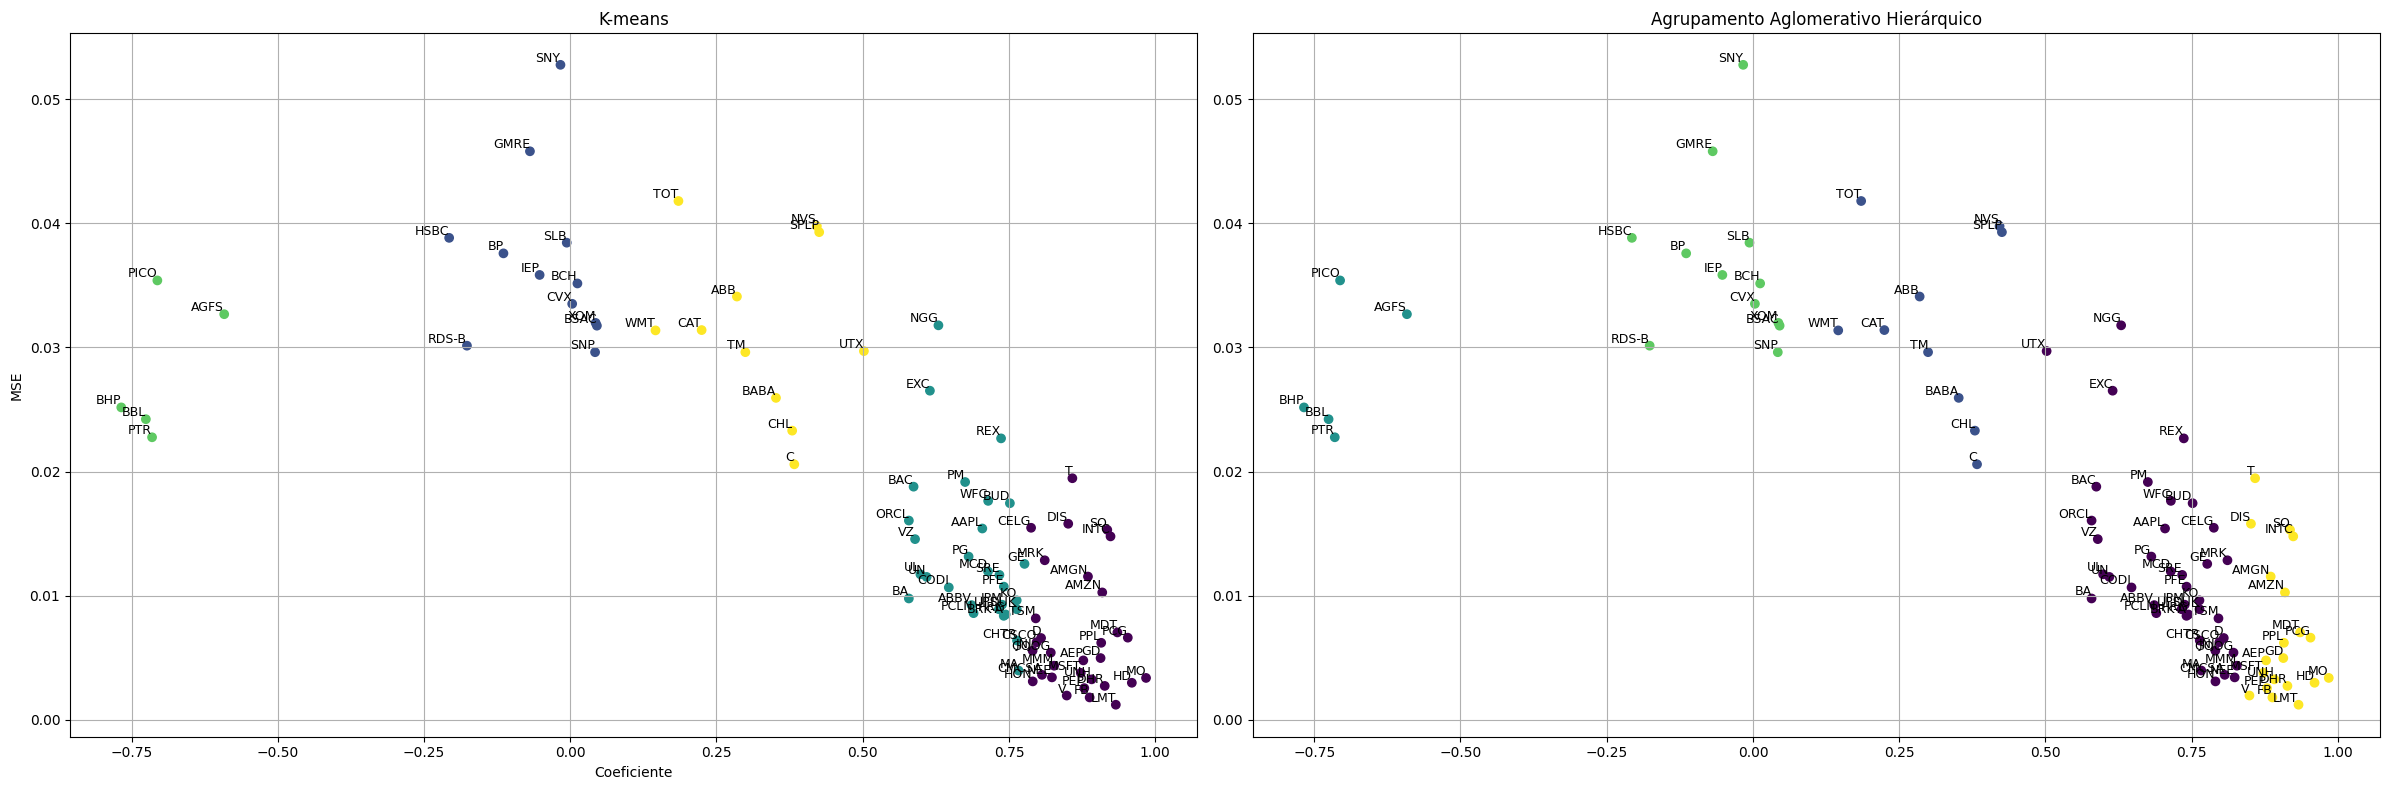

In [4]:
X_reg = results_df[['Coeficiente', 'MSE']]


kmeans = KMeans(n_clusters=5, random_state=0).fit(X_reg)
results_df['reg_Kmean_Cluster'] = kmeans.labels_

hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(X_reg)
results_df['reg_Hierarchical_Cluster'] = hierarchical_labels

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.scatter(results_df['Coeficiente'], results_df['MSE'], c=results_df['reg_Kmean_Cluster'], cmap='viridis', marker='o')
plt.xlabel('Coeficiente')
plt.ylabel('MSE')
plt.title('K-means')
plt.grid(True)
for i, row in results_df.iterrows():
    plt.text(row['Coeficiente'], row['MSE'], row['Ativo'], fontsize=9, ha='right', va='bottom')

plt.subplot(1, 2, 2)

plt.scatter(results_df['Coeficiente'], results_df['MSE'], c=results_df['reg_Hierarchical_Cluster'], cmap='viridis', marker='o')
plt.title('Agrupamento Aglomerativo Hierárquico')

plt.grid(True)
for i, row in results_df.iterrows():
    plt.text(row['Coeficiente'], row['MSE'], row['Ativo'], fontsize=9, ha='right', va='bottom')

plt.tight_layout()
plt.show()

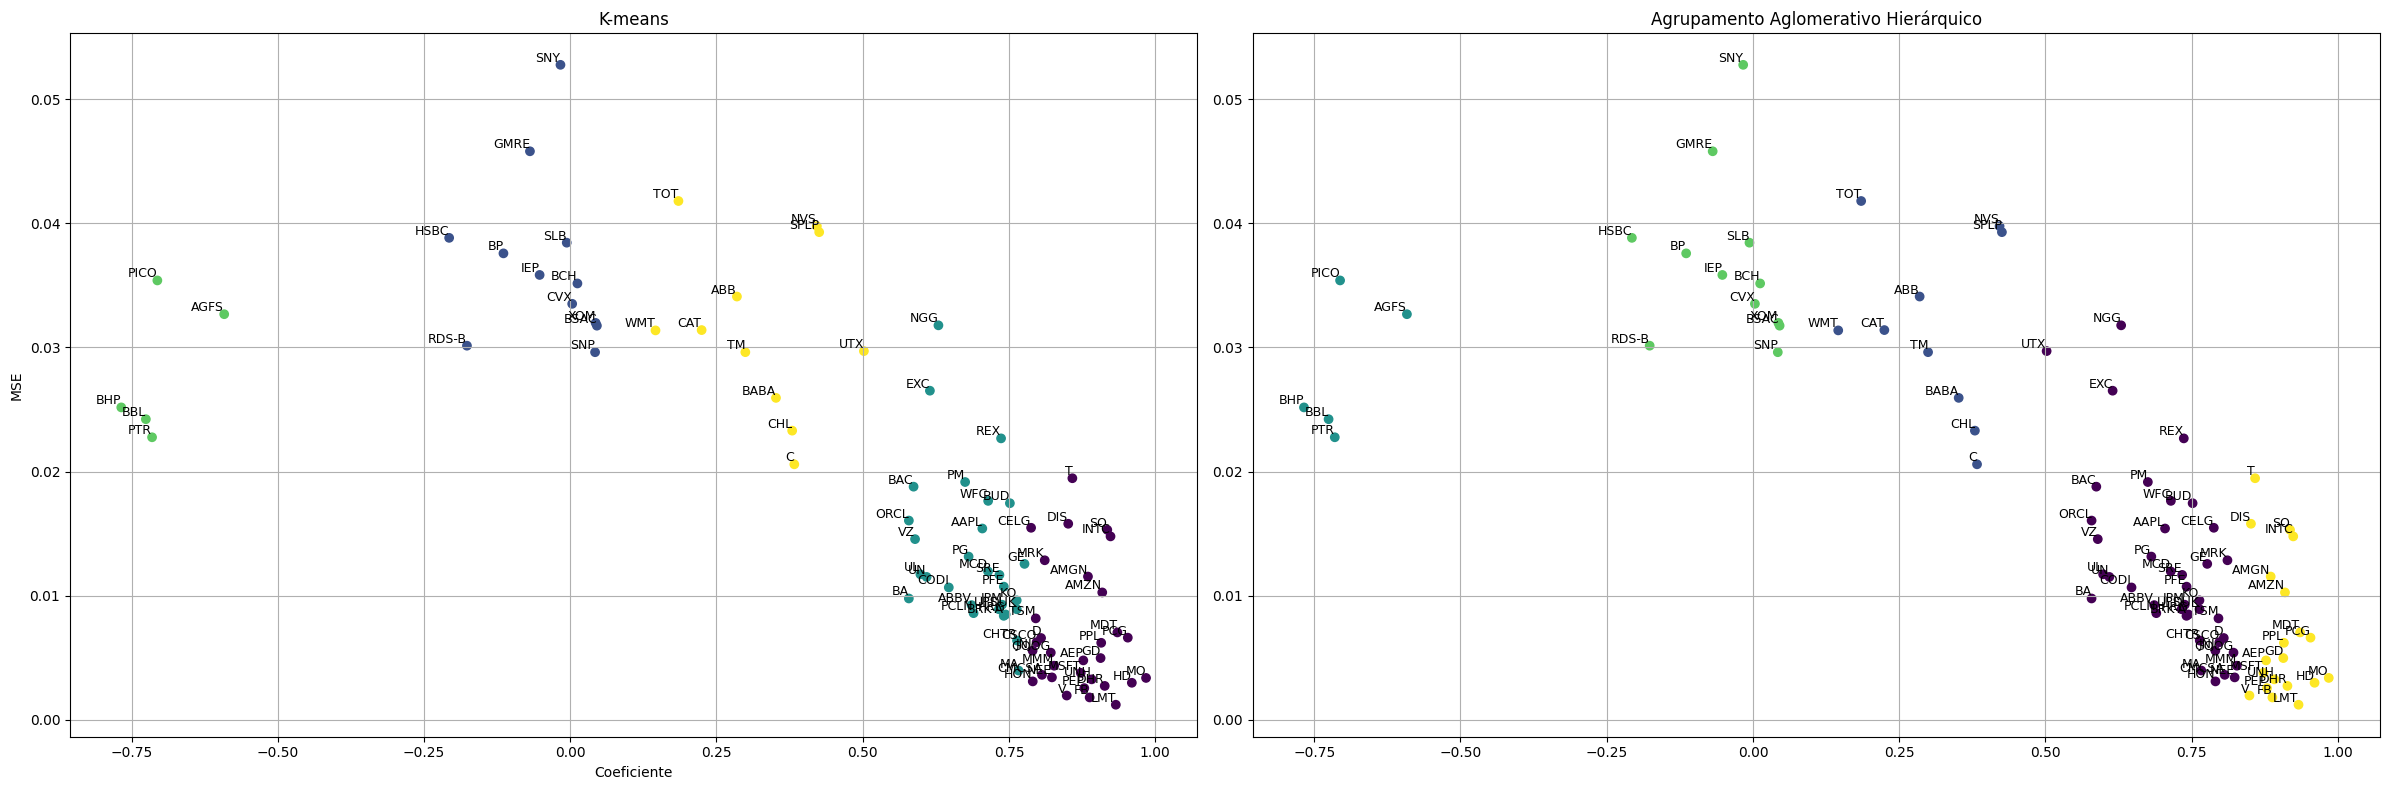

É importante destacar que, nesta abordagem, comparamos o comportamento das ações em relação a uma tendência linear, o que significa que os resultados não são diretamente aplicáveis para avaliar o retorno total de um investimento ao longo do período analisado. Em vez disso, a análise foca em identificar a consistência do comportamento das ações frente à sua tendência estimada.

Os gráficos gerados a partir dessa abordagem revelaram que um número considerável de ativos seguiu bem uma tendência linear de crescimento, com coeficiente positivo e baixo MSE. Esses ativos podem ser vistos como opções mais "seguras", pois apresentam um retorno consistentemente positivo. Entre os destaques, a ação da Lockheed Martin (LMT) apresentou um comportamento praticamente linear, com uma taxa de crescimento bem definida e baixa variabilidade em relação à sua tendência.


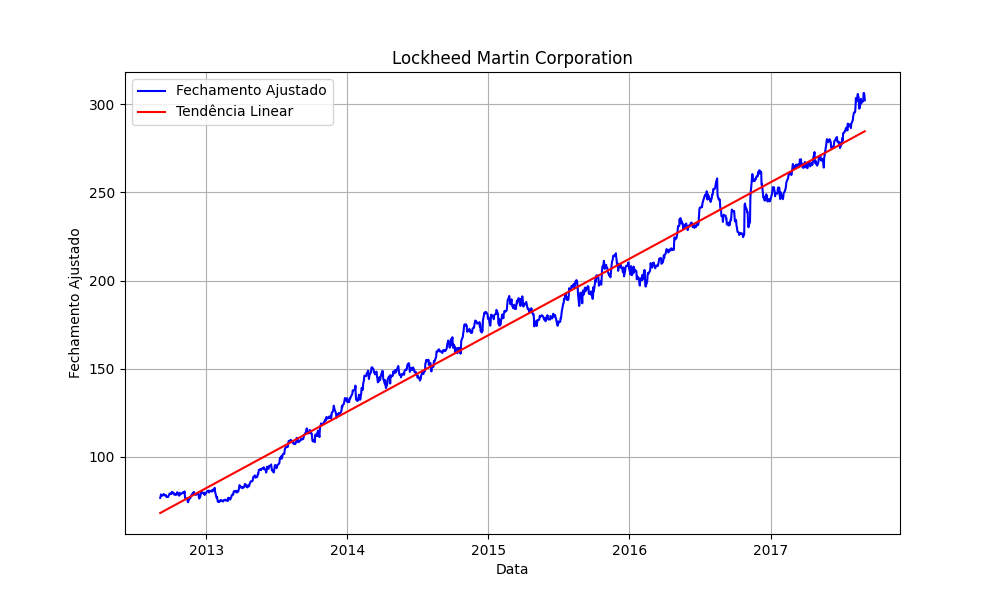



Curiosamente, nenhum ativo neste conjunto de dados demonstrou uma tendência consistente de queda. Quando identificados coeficientes negativos, eles estavam quase sempre associados a um MSE elevado, indicando que a ação não seguia uma tendência linear clara. Isso sugere que, embora possam ter ocorrido flutuações ou perdas pontuais, elas não formaram um padrão linear de declínio ao longo do período analisado.

Por fim, ao comparar os resultados dos algoritmos *k-means* e *agrupamento aglomerativo hierárquico*, observamos que ambos produziram agrupamentos semelhantes, baseados em maior parte no **valor do coeficiente**. Contudo, nesse caso específico, as diferenças entre os métodos foram um pouco mais perceptíveis, embora ainda indicando que os dois algoritmos podem ser considerados intercambiáveis para essa abordagem.

---



### 3. Retorno Diário como Vetor
Enquanto as abordagens anteriores analisaram aspectos resumidos dos dados, sentimos que seria importante capturar a granularidade das variações diárias nos preços das ações. Para isso, transformamos o histórico de preços em séries de retornos diários, criando vetores que representavam cada ativo em termos de suas flutuações diárias.

Esses vetores encapsulavam todo o histórico de volatilidade de cada ação, permitindo uma análise mais detalhada de seus comportamentos.  Contudo, foi necessário remover 7 ações da análise, pois seus dados históricos não cobriam o período completo das demais.

Visto o desempenho similar dos algoritmos de clustering, utilizamos apenas *k-mean* nessa abordagem.

In [5]:
#Cria dataframe onde cada linha é o vetor de uma ação
vetor_df = pd.DataFrame(vectors)
#Remove a primeira coluna pois o primeiro retorno diario é a partir do segundo dia
vetor_df = pd.DataFrame(vetor_df['Vetor'].tolist(), index=vetor_df['Ativo']).drop(columns=[0])

#Remove ações que não estão no periodo completo (por terem surgido depois do periodo inicial, por exemplo)
vetor_df = vetor_df.dropna()

Para definir um numero otimo de clusters, podemos utilizar o [Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/), também descrito no proprio artigo de *Fernandez*. No entanto, os resultados não são conclusivos, e podemos entender que realizar clustering em um espaço de 1252 dimensões está levando a um caso de *Curse of Dimensionality*, fenômeno no qual o aumento do número de dimensões reduz a eficácia das métricas de distância utilizadas pelos algoritmos de clustering.

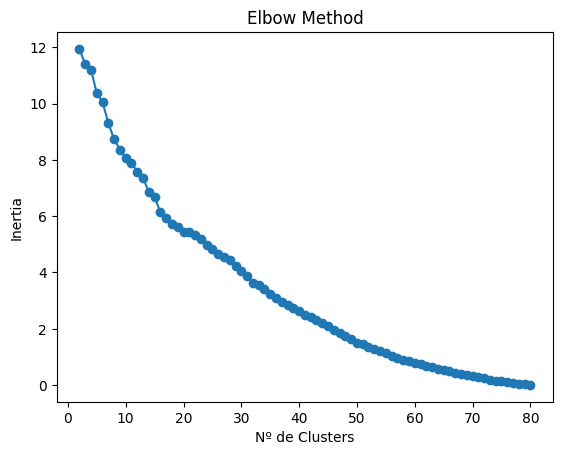

In [6]:
inertia = []
k_range = range(2, 81)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(vetor_df)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Nº de Clusters')
plt.ylabel('Inertia')
plt.show()

Para mitigar esse problema, decidimos aplicar o método de PCA (*Principal Component Analysis*), que permite reduzir a dimensionalidade dos dados enquanto preserva a maior parte da variabilidade original.

In [7]:
#https://www.geeksforgeeks.org/kmeans-clustering-and-pca-on-wine-dataset/
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler =StandardScaler()

scaled_vetor_df =  scaler.fit_transform(vetor_df)

#Existem metodos para definir o numero de componentes https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/Multivariate-Approaches/Principal-Component-Analysis/PCA-the-basics/Choose-Principal-Components/index.html
#Nesse caso, 7 é o numero maximo que permitiu utilizar o elbow method para o clustering
pca = PCA(n_components=7)

vetor_pca = pca.fit_transform(scaled_vetor_df)

vetor_pca = pd.DataFrame(vetor_pca, index=vetor_df.index)
vetor_pca.head(3)

0          1         2         3         4         5         6
Ativo                                                                        
AAPL   -2.079829  -8.699968  1.035867  6.527181  4.822624  8.849283 -3.640296
ABB    -8.791993   3.574327  0.870096 -1.842313 -1.322154  5.194013 -4.653378
AEP    19.150881  13.373581 -1.142683  5.117993  2.723248 -5.136703  4.811408

Assim, conseguimos identificar n=10 como sendo o melhor número de clusters.

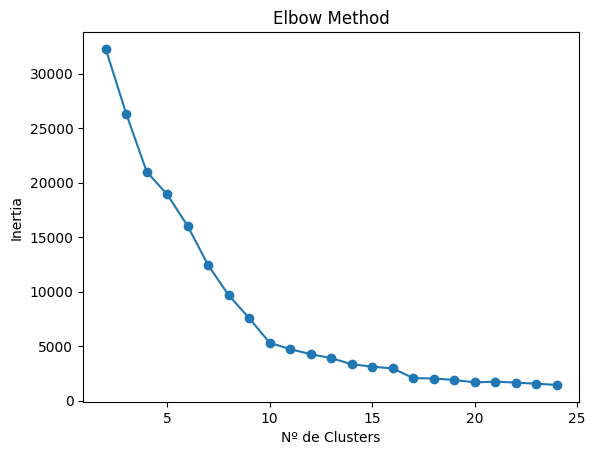

In [8]:
inertia = []
k_range = range(2, 25)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(vetor_pca)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Nº de Clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(vetor_pca)

kmeans.labels_

results_df = pd.merge(results_df, pd.DataFrame(kmeans.labels_, index=vetor_df.index, columns=['Vetor_Temporal_Cluster']), left_on="Ativo",right_index=True, how="left")

In [10]:
results_df[['Ativo','Setor','Nome','Vetor_Temporal_Cluster']].sort_values(by=['Vetor_Temporal_Cluster'])

Ativo             Setor                           Nome  \
19  CELG        Healthcare            Celgene Corporation   
5   AMGN        Healthcare                     Amgen Inc.   
29   DUK         Utilities        Duke Energy Corporation   
53   NEE         Utilities           NextEra Energy Inc.    
26     D         Utilities           Dominion Energy Inc.   
..   ...               ...                            ...   
8   BABA          Services          Alibaba Group Holding   
34  GMRE     Conglomerates            Global Medical REIT   
65   PTR  Basic Matierials     PetroChina Company Limited   
67   REX     Conglomerates         REX American Resources   
69   SNP  Basic Matierials  China Petroleum & Corporation   

    Vetor_Temporal_Cluster  
19                     0.0  
5                      0.0  
29                     1.0  
53                     1.0  
26                     1.0  
..                     ...  
8                      NaN  
34                     NaN  
65                     NaN  
67                     NaN  
69                     NaN  

[88 rows x 4 columns]

Diferentemente das duas primeiras abordagens, esta última apresentou maior complexidade na interpretação e visualização dos clusters formados. Como os dados estão representados em um espaço de alta dimensionalidade, a ideia principal é que ações que valorizam e desvalorizam juntas ao longo do tempo devem estar próximas nesse espaço, formando agrupamentos com base em padrões similares de variação diária.

Com uma análise qualitativa dos resultados, foi possível identificar algumas características que uniam certos clusters:

- Um dos clusters, por exemplo, era composto por duas empresas do setor de saúde, indicando um comportamento conjunto em termos de valorização e desvalorização.

|index|Ativo|Setor|Nome|Vetor\_Temporal\_Cluster|
|---|---|---|---|---|
|5|AMGN|Healthcare|Amgen Inc\.|0|
|19|CELG|Healthcare|Celgene Corporation|0|

- Outro cluster foi formado exclusivamente por empresas do setor de *Utilities*

|index|Ativo|Setor|Nome|Vetor\_Temporal\_Cluster|
|---|---|---|---|---|
|29|DUK|Utilities|Duke Energy Corporation|1|
|53|NEE|Utilities|NextEra Energy Inc\. |1|
|26|D|Utilities|Dominion Energy Inc\.|1|
|73|SRE|Utilities|Sempra Energy|1|
|71|SO|Utilities|The Southern Company|1|
|30|EXC|Utilities|Exelon Corporation|1|
|57|PCG|Utilities|PG&E Corporation|1|
|3|AEP|Utilities|American Electric Power Inc\.|1|
|64|PPL|Utilities|PPL Corporation|1|

- Além disso, foi identificado outro cluster composto apenas por bancos.

|index|Ativo|Setor|Nome|Vetor\_Temporal\_Cluster|
|---|---|---|---|---|
|9|BAC|Financial|Bank of America|3|
|85|WFC|Financial|Wells Fargo & Co\.|3|
|17|C|Financial|Citigroup Inc\.|3|
|43|JPM|Financial|JPMorgan Chase & Co\.|3|

Apesar da dificuldade em interpretar os agrupamentos diretamente, essa abordagem demonstra seu potencial para identificar relações mais sutis entre ações, especialmente aquelas pertencentes a setores ou grupos econômicos similares.

#Conclusões

Esse trabalho reforça o potencial do aprendizado de máquina na análise do mercado financeiro, não apenas como uma ferramenta de previsão, mas também como suporte para decisões estratégicas de investimento, enriquecendo abordagens qualitativas tradicionais com uma metodologia computacional e quantitativa, sendo possível explorar padrões de comportamento de ações de forma escalável.

Os resultados indicaram que, para o conjunto de dados e abordagens utilizadas, os algoritmos *k-means* e *agrupamento aglomerativo hierárquico* apresentaram desempenhos bastante similares, reforçando a intercambialidade entre eles. Contudo, ficou evidente que o aspecto mais crítico no sucesso do modelo foi o processo de **engenharia de features**, que determinou diretamente a relevância e a utilidade dos agrupamentos formados.

Como próximos passos, seria interessante explorar métodos adicionais de aprendizado de máquina, como o uso de Redes Neurais para codificação de series historicas e extração de features.



### Bibliotecas utilizadas

*   [Pandas](https://pandas.pydata.org/)
*   [matplotlib](https://matplotlib.org/)
*   [scikit-learn](https://scikit-learn.org/stable/)

### [Repositório do projeto](https://github.com/leonardogarca/AM_Stock-Clustering)

